In [1]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

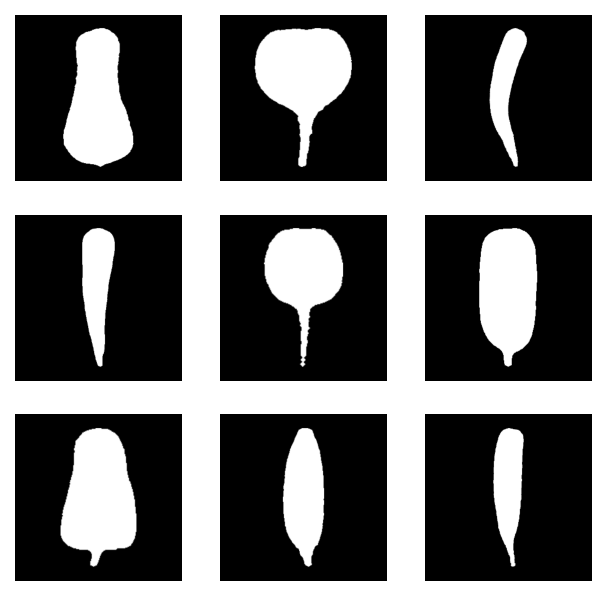

In [2]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)

In [3]:
import time

def meanerr(func, ts, Samples):
  sps = Samples
  fx, fy = func
  t = symbols('t')
  nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
  onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
  return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func = bez.fit0(tpara=[])
      etime = time.process_time() - start
      odds = rd.isOverFitting(func,bez.ts,conAll,tover=0.1,tunder=-0.1)
      err = meanerr(func,bez.ts,Samples)
      results[str(N)] = (odds,err,etime)
      if err < err_th:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

In [4]:
#実輪郭の標本点間の輪郭長と近似曲線の対応区間長との差の分布において、４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting2(func,ts,cont,of_th=0.5):
    if len(cont) == 0:
        return []
    Nsamples = len(ts)
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    lengths = np.array([cv2.arcLength(cont[:i+1], closed=False) for i in range(len(cont))])
                                                    # 始点から全輪郭点にいたる弧長
    spidx = np.array([np.abs(lengths - i).argmin() for i in np.linspace(0, axlength, Nsamples)])
                                                    # 等間隔にとった標本点のインデックス
    rs1 = []
    for i in range(Nsamples-1):
        qls = np.linspace(lengths[spidx[i]],lengths[spidx[i+1]],5)
        qidx = np.array([np.abs(lengths - l).argmin() for l in qls])
        rq5 = np.array([cont[s] for s in qidx]) 
        rs1.append(rq5) # 各区分の両端と4分割点計5点ずつのリスト
    # 近似曲線側の弧長を計算する
    rs2 = []
    fx,fy = func
    nfx, nfy = lambdify('t', fx, "numpy"), lambdify('t', fy, "numpy")
    for i in range(Nsamples-1):
        d5 = rd.getDenseParameters(func, st=ts[i], et=ts[i+1], n_samples=5) # 標本点のパラメタ間を4分割
        aq5 = np.array([[nfx(s),nfy(s)] for s in d5]) # 近似曲線上で区間を4等分する座標のリスト
        rs2.append(aq5)
    # 
    difs = np.array([np.std(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75, q25 = np.percentile(difs, [75,25]) # 四分位点
    odds0 = np.where((difs>q75+1.5*(q75-q25))) # 異常値のインデックス
    odds = np.where(difs > of_th*span)[0] # 
    print(odds,[difs[i] for i in odds0],odds0,"span",span)
    print(difs)
    print([[np.array(rs1[i])-np.array(rs2[i]),rs1[i],rs2[i]] for i in odds0[0]])
    return odds # 

#実輪郭の標本点間の輪郭長と近似曲線の対応区間長との差の分布において、４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting3(func,ts,cont,of_th=0.5):
    if len(cont) == 0:
        return []
    Nsamples = len(ts)
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    lengths = np.array([cv2.arcLength(cont[:i+1], closed=False) for i in range(len(cont))])
                                                    # 始点から全輪郭点にいたる弧長
    spidx = np.array([np.abs(lengths - i).argmin() for i in np.linspace(0, axlength, Nsamples)])
                                                    # 等間隔にとった標本点のインデックス
    rs1 = []
    for i in range(Nsamples-1):
        qls = np.linspace(lengths[spidx[i]],lengths[spidx[i+1]],5)
        qidx = np.array([np.abs(lengths - l).argmin() for l in qls])
        rq5 = np.array([cont[s] for s in qidx]) 
        rs1.append(rq5) # 各区分の両端と4分割点計5点ずつのリスト
    # 近似曲線側の弧長を計算する
    rs2 = []
    fx,fy = func
    nfx, nfy = lambdify('t', fx, "numpy"), lambdify('t', fy, "numpy")
    for i in range(Nsamples-1):
        d5 = rd.getDenseParameters(func, st=ts[i], et=ts[i+1], n_samples=5) # 標本点のパラメタ間を4分割
        aq5 = np.array([[nfx(s),nfy(s)] for s in d5]) # 近似曲線上で区間を4等分する座標のリスト
        rs2.append(aq5)
    # 
    difs = np.array([np.std(np.sum((rq5-aq5)*(rq5-aq5),axis=1)) for (rq5,aq5) in zip(rs1,rs2)])
    q75, q25 = np.percentile(difs, [75,25]) # 四分位点
    odds0 = np.where((difs>q75+1.5*(q75-q25))) # 異常値のインデックス
    odds = np.where(difs > of_th*span)[0] # 
    print(odds,[difs[i] for i in odds0],odds0,"span",span)
    return odds # 

標本点間平均間隔

In [5]:
for imgn in range(9):
    img = imgs[imgn]
    cont = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Nsamples = 65
    # 実輪郭線側の標本点間弧長を計算する
    axlength = np.array(cv2.arcLength(cont,closed=False))  # 全周の長さ
    span = axlength/(Nsamples-1)
    print(imgn,axlength,span)

0 682.1442233324051 10.65850348956883
1 750.6122596263885 11.728316556662321
2 592.5168067216873 9.258075105026364
3 570.2081507444382 8.909502355381846
4 725.0142805576324 11.328348133713007
5 630.4751765727997 9.851174633949995
6 697.1025931835175 10.89222801849246
7 584.0193328857422 9.125302076339722
8 569.7644996643066 8.902570307254791


標本点間の輪郭点列を距離で４等分したときの４分位点3点と標本点2点の計5点の位置ずれの標本偏差を平均区間長で割った値がしきい値（デフォルト０．５）以上であればオーバフィッティングであると判断することにする。

In [5]:
def testOF(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,mode=1,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1T(tpara=[],mode=mode,err_th=err_th,lr=lr,lrP=lrP,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,isOverFitting3(func,bez.ts,conAll,of_th=of_th),func

def testOF1(imgn=0,N=7,lr=0.001,lrP=30000,pat=1000,err_th=1.0,of_th=0.5):
    img = imgs[imgn]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func,err = bez.fit1(tpara=[],err_th=err_th,pat=pat,withErr=True)
    rd.drawBez(imgs[imgn],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return err,rd.isOverFitting(func,bez.ts,conAll,of_th=of_th)

^^^^^^^^
CP 5.0, steps:7, etime: 6.14062 err: 4.0594037783
^^^^^^^^.^^^^.
CP 2.0, steps:21, etime: 9.23438 err: 1.8333705253
^^.^^.^.......................................................................
......................................................................^^^^^^^^^^^^^^................
........................^^^^^^^^^^^.^.^...................................^^^^^^^^^^^^.^.E



(0.999832115165081, array([], dtype=int64))

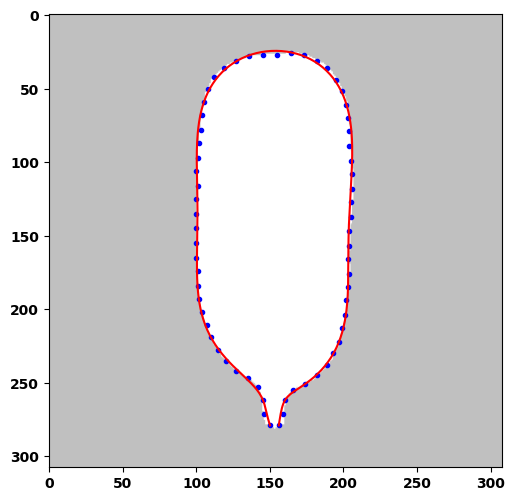

In [52]:
testOF(imgn=5,N=11,mode=0,err_th=1)

^^^^^^^^^^^^^^.^.
CP 5.0, steps:16, etime: 7.65625 err: 4.7534996104
^^.^^.^^.^.........................................................................
....................................................................................................
..................^^^^^^^^^^^^^^.
CP 2.0, steps:232, etime: 51.92188 err: 1.9828193016
....^..........................................^^^^^^^^^^^^^^^.....
.....................................................^^^^^^^^^^^^^^^^^.....^........................
.........................^^^^^^^^^^^^^^^^.^....^.^...........................................^^^^^^^
^^^^^^^^^^^^^^.^.^^^^^^.^.^^^^^^.^^^^^^^^.^.^.^^^.^^^^^^.^.^.^.^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^.^^^^
.^.^.E



(0.9988589651642037, array([0], dtype=int64))

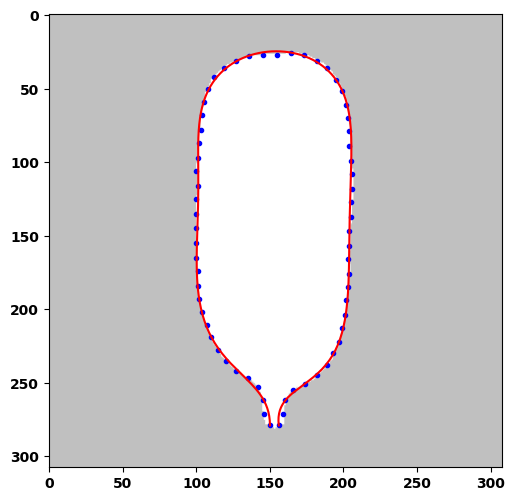

In [51]:
testOF(imgn=5,N=10,mode=0,err_th=1)

^^^^^^^.^^^^.^.
CP 5.0, steps:14, etime: 6.78125 err: 3.5340520569
^^^^.^^.^^.^^.^.........................^^^^^^^^^^^^^^^^^^^^^^^^^....................
............^^^^^^^^^^^^.^^^.^....................................^^^^^^^^^^^^^.^^.^...........
CP 2.0, steps:194, etime: 40.48438 err: 1.9980757171
.....
..............................^^^^^^^^^^^^^^^.^...^.................................................
.^^^^^^^^^^^^^^^^^^...........................................................^^^^^^^^^^^^^^^^.^.^.^
...^..........................................^^^^^^^^^^^^^^^^^^^^^.......^.........................
.................^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
.^^^^.^.^.^.^^^.^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^..^.^^.^.^.^^^^.^.^.^^^
^.^.^.^.^..^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.9957592178508918, array([0, 1], dtype=int64))

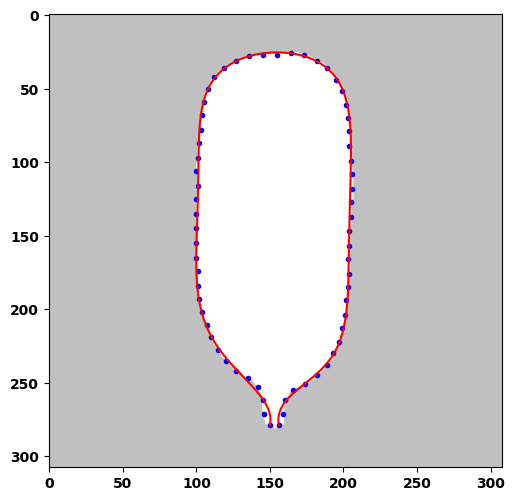

In [50]:
testOF(imgn=5,N=9,mode=0,err_th=1)

^^^^^^^^^.^.^....^..................................................................................
......
CP 5.0, steps:105, etime: 19.76562 err: 4.9971788256
...................................................^^^^^^^^^^^^^.^............................
......................^^^^^^.^^.^^.^....^..............................................^^^^^^^^^^^^^
.^^.^.^..........................^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^.^.^.^.^.^.......................^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^........^..^..^..^.^..^..........^^^^^^^^^^^^^^^^^^^^^..^.^^.^^^^^^^^^^^^
^^^^^^.^^^^^.^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^^..^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^.^^..^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^..^^.^
^..^^^^^^.^^.^^..^^.^^.^^^^^^^^^^^^^^^^^^^^^^^..^^^...^^^^^^^^^^^^^^^^^^^^.^^^^^^.^^^.^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^..^^^^.^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1.4774159909208204,
 array([23], dtype=int64),
 Matrix([
 [ 159.0*t**8 + 20.8746*t**7*(8 - 8*t) + 6264.66*t**6*(1 - t)**2 + 42603.1*t**5*(1 - t)**3 - 45409.2*t**4*(1 - t)**4 - 34504.7*t**3*(1 - t)**5 + 16217.1*t**2*(1 - t)**6 + 921.418*t*(1 - t)**7 + 166.0*(1 - t)**8],
 [280.0*t**8 - 80.2767*t**7*(8 - 8*t) - 12998.8*t**6*(1 - t)**2 + 57651.9*t**5*(1 - t)**3 + 32428.3*t**4*(1 - t)**4 - 121725.0*t**3*(1 - t)**5 + 6905.96*t**2*(1 - t)**6 + 683.996*t*(1 - t)**7 + 279.0*(1 - t)**8]]))

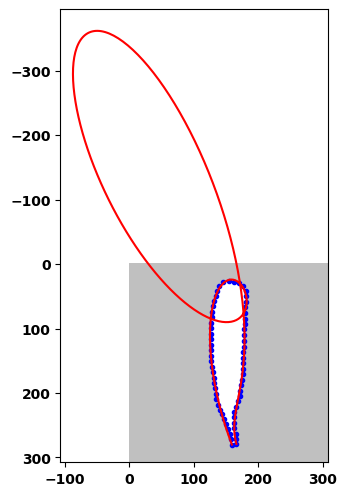

In [14]:
testOF(imgn=8,N=8,mode=0,err_th=1)

^^^^^^^^^.^.^...
CP 5.0, steps:15, etime: 6.84375 err: 4.9564795275
.^..^.^^.^^.^^......................................................................
.............................................................................^^^^^^^^^^^^^^.^^^.^...
^^^^^^^.
CP 2.0, steps:207, etime: 41.04688 err: 1.9987013042
^.^.^.^....^^^^^^^^^^^^^^^^.^^^^^.......................^^^^^^^^^^^^^^^^.^^^^...............
........^^^^^^^^^^^^^^..^^^^......^^^^^^^^^.^^^.^..^^^^^^^^^^.....^^^^...................^^^^^^^^^^.
.....^^.....................^^^^^......^^^^^^^.^^^^.^^.^..^..^..^.....................E



(0.9978437159267811, array([], dtype=int64))

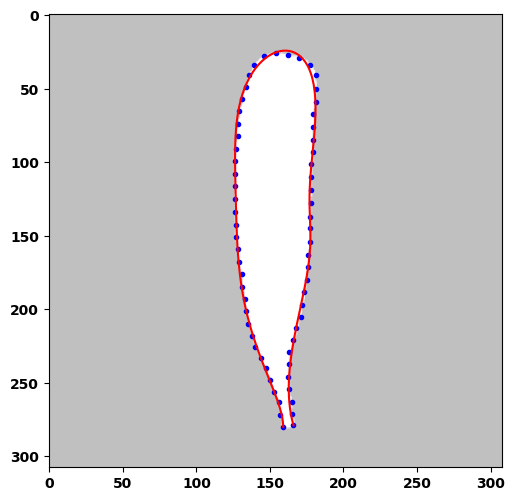

In [43]:
testOF(imgn=8,N=9,mode=0,err_th=1)

^^^^^^^^^.......
CP 5.0, steps:15, etime: 5.70312 err: 4.9140402959
.^.^..........
CP 2.0, steps:29, etime: 7.79688 err: 1.9702655240
......................................................................
..........................................................................^^^^^^^^^^^^^^.^^.........
............................................^^^^^^^^^^^^^^^^^^^.^^.^^.^^.
CP 1.0, steps:272, etime: 44.93750 err: 0.9950632943
^^..^.^^..^..^^.^..^^......
.....................^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^.......^..................^^^^^^^^^^^^^
^^^^^^.^^^^^^^^^^^^^^^^^^^^^^....^..^.
CP 0.65, steps:437, etime: 70.06250 err: 0.6477149574
................^^^^^^^^^^^^^^^^^^^.^.^.^.^.^.^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^.^^^^.^^^^.^^.^..E



(0.4998952312174142, array([], dtype=int64))

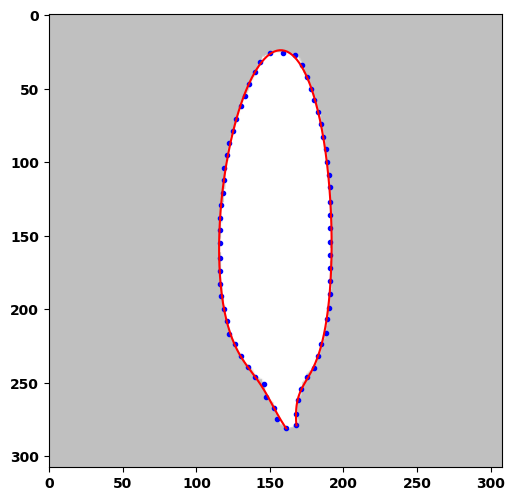

In [38]:
testOF(imgn=7,N=8,mode=0,err_th=0.5)

^^^.^.^.^.^.
CP 5.0, steps:11, etime: 4.23438 err: 3.7631725677
^..^.
CP 2.0, steps:16, etime: 4.87500 err: 1.5415875801
^^.^..^..^..^........................
CP 1.0, steps:53, etime: 9.70312 err: 0.9976155478
....................^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^.^^.^^.^^^^^^.^^.^^^^^^.^^^.^^^.^^..^...................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^
.^^^.^^.^^^.^^.^^..^..................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^..
CP 0.65, steps:352, etime: 48.07812 err: 0.6488446501
^....................................^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^......^....
......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^.^^.........................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^......................

(0.5454463490574472,
 array([], dtype=int64),
 Matrix([
 [161.0*t**7 + 103.743*t**6*(7 - 7*t) + 2474.45*t**5*(1 - t)**2 + 1307.28*t**4*(1 - t)**3 + 9603.22*t**3*(1 - t)**4 + 4333.02*t**2*(1 - t)**5 + 1207.34*t*(1 - t)**6 + 168.0*(1 - t)**7],
 [281.0*t**7 + 169.774*t**6*(7 - 7*t) + 6579.35*t**5*(1 - t)**2 - 1368.16*t**4*(1 - t)**3 - 16117.3*t**3*(1 - t)**4 + 11167.3*t**2*(1 - t)**5 + 1056.85*t*(1 - t)**6 + 279.0*(1 - t)**7]]))

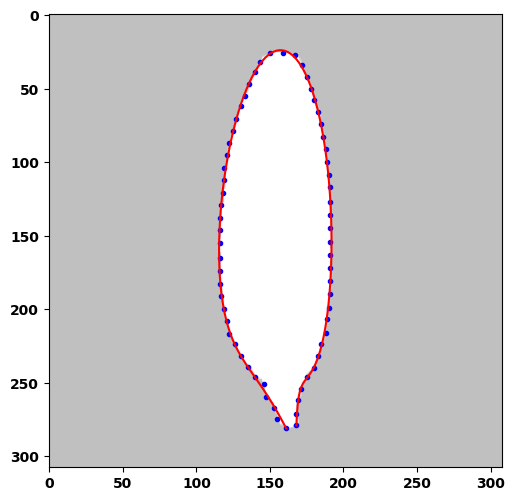

In [7]:
testOF(imgn=7,N=7,mode=0,err_th=0.5)

^^^.^.^.^.^.
CP 5.0, steps:11, etime: 3.93750 err: 3.7631725677
^..^.
CP 2.0, steps:16, etime: 4.56250 err: 1.5415875801
^^.^..^..^..^........................
CP 1.0, steps:53, etime: 9.32812 err: 0.9976155478
....................^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^.^^.^^.^^^^^^.^^.^^^^^^.^^^.^^^.^^..^...................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^
.^^^.^^.^^^.^^.^^..^..................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^..E



(0.6488446500576572, array([], dtype=int64))

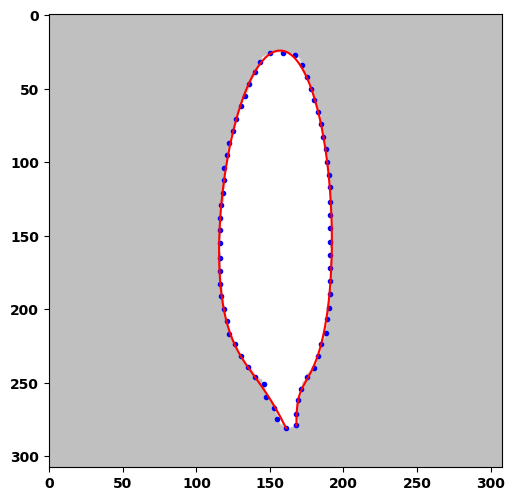

In [42]:
testOF(imgn=7,N=7,mode=0,err_th=0.65)

^^^^^^^.^.^.^..
CP 5.0, steps:14, etime: 3.50000 err: 4.5679356486
.....
CP 2.0, steps:19, etime: 4.18750 err: 1.6232158622
^..^..^..^^..^................................................................^^
^^^^^^^^^^^^^........................................^^^^^^^^^^^^^^^^^^......................
CP 1.0, steps:192, etime: 22.85938 err: 0.9993519812
.......
...................^^^^^^^^^^^^^^^^^^.^^.^^.^^.^^.^^..^..^.........................^^^^^^^^^^^^^^^^^
^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^.^.^^^.^.^.^...............................^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^......^.^^^^^^^^^^
^.^^^^.^^^^.^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^.^^.^...............^^^^^^^^^^^^^^^^^.....^.^.............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^^^^^..............................^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6570683640062621,
 array([], dtype=int64),
 Matrix([
 [ 161.0*t**6 + 100.215*t**5*(6 - 6*t) + 913.338*t**4*(1 - t)**2 + 3662.38*t**3*(1 - t)**3 + 3883.01*t**2*(1 - t)**4 + 979.23*t*(1 - t)**5 + 168.0*(1 - t)**6],
 [281.0*t**6 + 156.817*t**5*(6 - 6*t) + 5445.61*t**4*(1 - t)**2 - 13545.6*t**3*(1 - t)**3 + 7145.73*t**2*(1 - t)**4 + 1051.41*t*(1 - t)**5 + 279.0*(1 - t)**6]]))

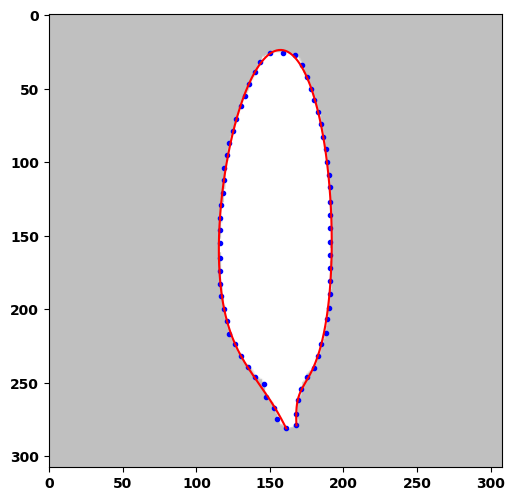

In [8]:
testOF(imgn=7,N=6,mode=0,err_th=0.65)

^^^.^.^.^.^.
CP 5.0, steps:11, etime: 3.92188 err: 3.7631725677
^..^.
CP 2.0, steps:16, etime: 4.54688 err: 1.5415875801
^^.^..^..^..^........................
CP 1.0, steps:53, etime: 9.26562 err: 0.9976155478
....................^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^.^^.^^.^^^^^^.^^.^^^^^^.^^^.^^^.^^..^...................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^
.^^^.^^.^^^.^^.^^..^..................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^..
CP 0.65, steps:352, etime: 47.78125 err: 0.6488446501
^....................................^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^......^....
......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^.^^.........................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^......................

(0.5454463490574472,
 array([], dtype=int64),
 Matrix([
 [161.0*t**7 + 103.743*t**6*(7 - 7*t) + 2474.45*t**5*(1 - t)**2 + 1307.28*t**4*(1 - t)**3 + 9603.22*t**3*(1 - t)**4 + 4333.02*t**2*(1 - t)**5 + 1207.34*t*(1 - t)**6 + 168.0*(1 - t)**7],
 [281.0*t**7 + 169.774*t**6*(7 - 7*t) + 6579.35*t**5*(1 - t)**2 - 1368.16*t**4*(1 - t)**3 - 16117.3*t**3*(1 - t)**4 + 11167.3*t**2*(1 - t)**5 + 1056.85*t*(1 - t)**6 + 279.0*(1 - t)**7]]))

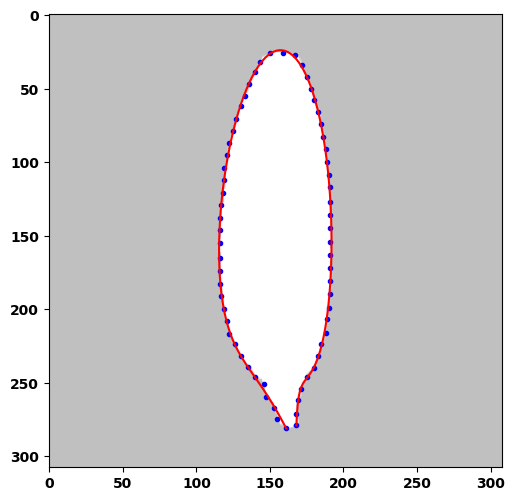

In [9]:
testOF(imgn=7,N=7,mode=0,err_th=0.5)

^^^^^^^^^.......
CP 5.0, steps:15, etime: 5.70312 err: 4.9140402959
.^.^..........
CP 2.0, steps:29, etime: 7.78125 err: 1.9702655240
......................................................................
..........................................................................^^^^^^^^^^^^^^.^^.........
............................................^^^^^^^^^^^^^^^^^^^.^^.^^.^^.
CP 1.0, steps:272, etime: 44.17188 err: 0.9950632943
^^..^.^^..^..^^.^..^^......
.....................^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^.......^..................^^^^^^^^^^^^^
^^^^^^.^^^^^^^^^^^^^^^^^^^^^^....^..^.
CP 0.65, steps:437, etime: 69.09375 err: 0.6477149574
................^^^^^^^^^^^^^^^^^^^.^.^.^.^.^.^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^.^^^^.^^^^.^^.^..E
[] [array([1.64041423, 2.03278169, 1.98960824])] (array([31, 59, 63], dtype=int64),) span 9.125302076339722


(0.4998952312174142,
 array([], dtype=int64),
 Matrix([
 [161.0*t**8 + 120.671*t**7*(8 - 8*t) + 4811.96*t**6*(1 - t)**2 - 3606.32*t**5*(1 - t)**3 + 18798.1*t**4*(1 - t)**4 + 10554.6*t**3*(1 - t)**5 + 6267.39*t**2*(1 - t)**6 + 1297.97*t*(1 - t)**7 + 168.0*(1 - t)**8],
 [281.0*t**8 + 222.643*t**7*(8 - 8*t) + 5068.99*t**6*(1 - t)**2 + 28649.8*t**5*(1 - t)**3 - 57427.0*t**4*(1 - t)**4 + 18686.0*t**3*(1 - t)**5 + 7234.45*t**2*(1 - t)**6 + 1706.95*t*(1 - t)**7 + 279.0*(1 - t)**8]]))

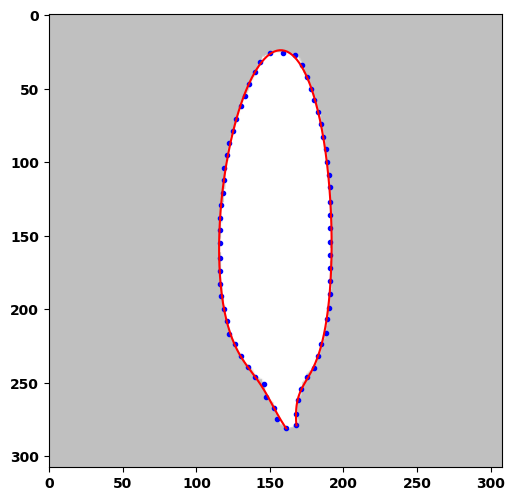

In [10]:
testOF(imgn=7,N=8,mode=0,err_th=0.5)

..
CP 5.0, steps:1, etime: 7.00000 err: 4.9724672526
.................
CP 2.0, steps:18, etime: 28.23438 err: 1.9695702477
.....................................E



(0.9959101868561177, array([], dtype=int64))

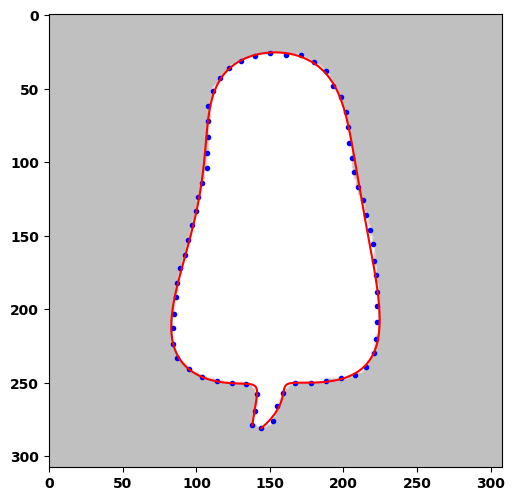

In [47]:
testOF(imgn=6,N=11,mode=1,err_th=1)

^^^^^^^^^^^^^^^.
CP 5.0, steps:15, etime: 9.46875 err: 4.9135792371
.....^.....................................
CP 2.0, steps:58, etime: 21.43750 err: 1.9968584456
.........................................
...........................................................................^^^^^^..^^^^^^^^^^^.^^.^.
^..^.^.^..^^^^^^^..
CP 1.0, steps:218, etime: 66.25000 err: 0.9712357998
^^^...^..................^^^^^^^^^^^^^^^.^.^.^.^.^^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^
...
CP 0.65, steps:302, etime: 90.39062 err: 0.6470094048
...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^.^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5142990866332344,
 array([], dtype=int64),
 Matrix([
 [    144.0*t**13 + 201.637*t**12*(13 - 13*t) + 2621.87*t**11*(1 - t)**2 + 194224.0*t**10*(1 - t)**3 + 305519.0*t**9*(1 - t)**4 - 2.71361e+6*t**8*(1 - t)**5 + 7.81374e+6*t**7*(1 - t)**6 - 6.70024e+6*t**6*(1 - t)**7 + 2.36441e+6*t**5*(1 - t)**8 + 6035.42*t**4*(1 - t)**9 - 5257.79*t**3*(1 - t)**10 - 1937.06*t**2*(1 - t)**11 + 2254.11*t*(1 - t)**12 + 138.0*(1 - t)**13],
 [281.0*t**13 + 263.627*t**12*(13 - 13*t) - 13138.4*t**11*(1 - t)**2 + 575504.0*t**10*(1 - t)**3 - 2.57069e+6*t**9*(1 - t)**4 + 5.46989e+6*t**8*(1 - t)**5 - 4.46378e+6*t**7*(1 - t)**6 - 292110.0*t**6*(1 - t)**7 + 2.33903e+6*t**5*(1 - t)**8 - 1.03996e+6*t**4*(1 - t)**9 + 172769.0*t**3*(1 - t)**10 + 25625.8*t**2*(1 - t)**11 + 2247.68*t*(1 - t)**12 + 279.0*(1 - t)**13]]))

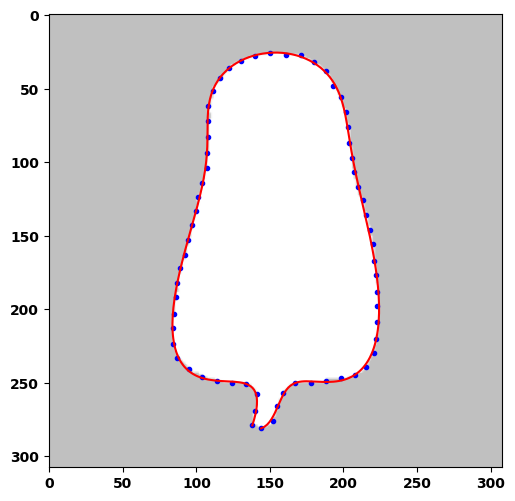

In [11]:
testOF(imgn=6,N=13,mode=0,err_th=0.5)

^^^^^^^^^^^^^^^.
CP 5.0, steps:15, etime: 10.09375 err: 4.9135792371
.....^.....................................
CP 2.0, steps:58, etime: 21.87500 err: 1.9968584456
.........................................
...........................................................................^^^^^^..^^^^^^^^^^^.^^.^.
^..^.^.^..^^^^^^^..
CP 1.0, steps:218, etime: 66.90625 err: 0.9712357998
^^^...^..................^^^^^^^^^^^^^^^.^.^.^.^.^^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^
...
CP 0.65, steps:302, etime: 90.59375 err: 0.6470094048
...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^.^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5142990866332344,
 array([ 6, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 55, 57], dtype=int64))

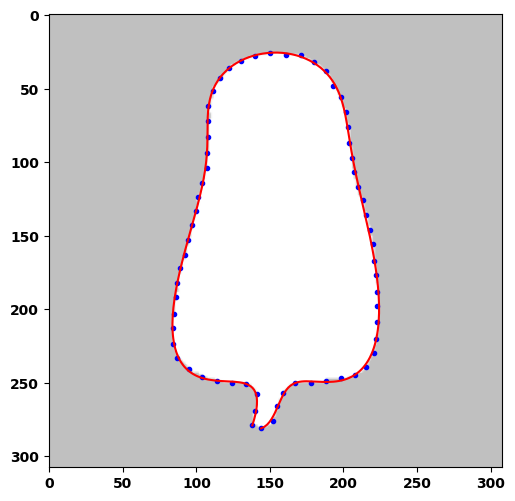

In [41]:
testOF(imgn=6,N=13,mode=0,err_th=0.5)

^^^^^^^^^^^^^^^^.
CP 5.0, steps:16, etime: 9.26562 err: 4.2182865223
^^.^.^^........................^..^^^.......................^^^^...................
...^^^............
CP 2.0, steps:117, etime: 35.93750 err: 1.9995161449
............^^^...^^................^^^...^^.......................^^^^...^^.....^
^^^^^^.^.^.........^^^^^^..^..........................^^^^^^^^^^^^^.
CP 1.0, steps:267, etime: 76.04688 err: 0.9893683434
............................^^^^
^^^^^^^^^^^^^^^^^^^^..^....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^.........
CP 0.65, steps:417, etime: 116.42188 err: 0.6493791079
........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^.^.^.^^^^^^^^.^.^.^.^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.4974116872899298, array([], dtype=int64))

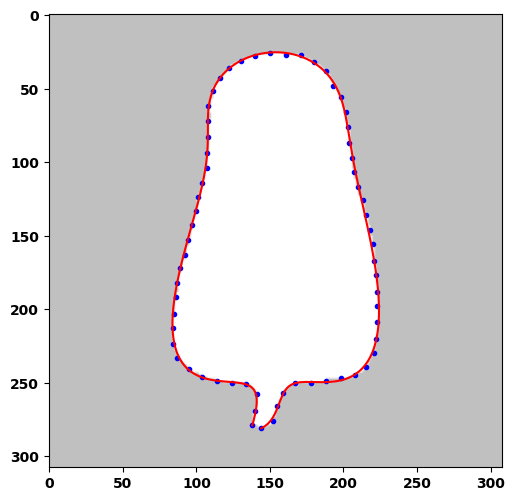

In [48]:
testOF(imgn=6,N=12,mode=0,err_th=0.5,pat=1500)

^^^^^^^^^^^^^^^^.
CP 5.0, steps:16, etime: 8.89062 err: 4.2182865223
^^.^.^^........................^..^^^.......................^^^^...................
...^^^............
CP 2.0, steps:117, etime: 34.85938 err: 1.9995161449
............^^^...^^................^^^...^^.......................^^^^...^^.....^
^^^^^^.^.^.........^^^^^^..^..........................^^^^^^^^^^^^^.
CP 1.0, steps:267, etime: 72.60938 err: 0.9893683434
............................^^^^
^^^^^^^^^^^^^^^^^^^^..^....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^.........
CP 0.65, steps:417, etime: 110.40625 err: 0.6493791079
........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^.^.^.^^^^^^^^.^.^.^.^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5009132244540628, array([], dtype=int64))

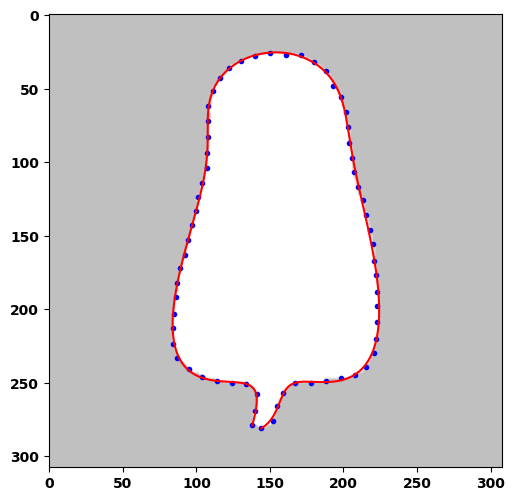

In [44]:
testOF(imgn=6,N=12,mode=0,err_th=0.5)

^^^^^^^^^^^^^^^^.
CP 5.0, steps:16, etime: 8.87500 err: 4.2182865223
^^.^.^^........................^..^^^.......................^^^^...................
...^^^............
CP 2.0, steps:117, etime: 34.64062 err: 1.9995161449
............^^^...^^................^^^...^^.......................^^^^...^^.....^
^^^^^^.^.^.........^^^^^^..^..........................^^^^^^^^^^^^^.
CP 1.0, steps:267, etime: 73.09375 err: 0.9893683434
............................^^^^
^^^^^^^^^^^^^^^^^^^^..^....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^.........E



(0.6493791078917536, array([], dtype=int64))

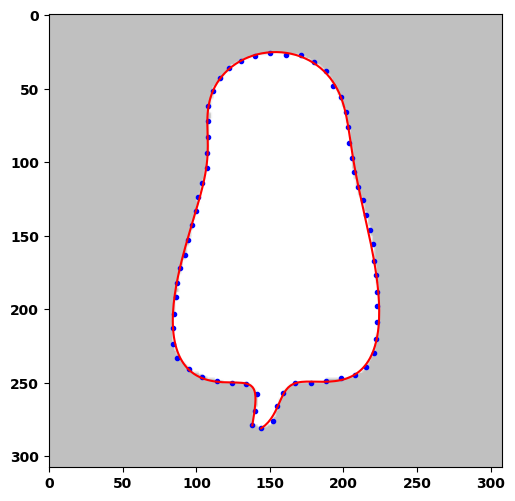

In [34]:
testOF(imgn=6,N=12,mode=0,err_th=0.65)

^^^^^^^^^^^.^..^.^..^.
CP 5.0, steps:21, etime: 9.50000 err: 4.6200057650
^^.^..........................................................................
.......................................................................^^^^^.^^...^.................
........................^^^^^^^^^.
CP 2.0, steps:233, etime: 58.53125 err: 1.9899104783
^........................................^^^^^^^^^^.^.^...........
..........................^^^^^^^^^^.^.^....^...............................^^^^^^^^.^^^^^^.^..^....
^^^^^^^^^^..^^......................^^^^^^^^^^^^^^^^^^^^^^^^....................^.^.^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^.^.^.^.^^^^^.^^^.^.....^.^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^.^^^^^^^^^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.9996541491958801, array([ 2, 63], dtype=int64))

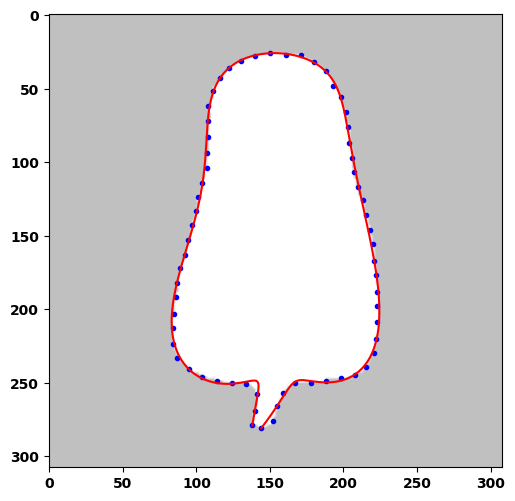

In [33]:
testOF(imgn=6,N=11,mode=0,err_th=1)

^^^^^^^^^^^^^^.^.
CP 5.0, steps:16, etime: 7.64062 err: 4.7534996104
^^.^^.^^.^.........................................................................
....................................................................................................
..................^^^^^^^^^^^^^^.
CP 2.0, steps:232, etime: 52.06250 err: 1.9828193016
....^..........................................^^^^^^^^^^^^^^^.....
.....................................................^^^^^^^^^^^^^^^^^.....^........................
.........................^^^^^^^^^^^^^^^^.^....^.^...........................................^^^^^^^
^^^^^^^^^^^^^^.^.^^^^^^.^.^^^^^^.^^^^^^^^.^.^.^^^.^^^^^^.^.^.^.^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^.^^^^
.^.^.
CP 1.0, steps:704, etime: 149.32812 err: 0.9988589652
^^^^^^^^^^^^.^.^.^.^.^.^^^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.49757945613396715, array([], dtype=int64))

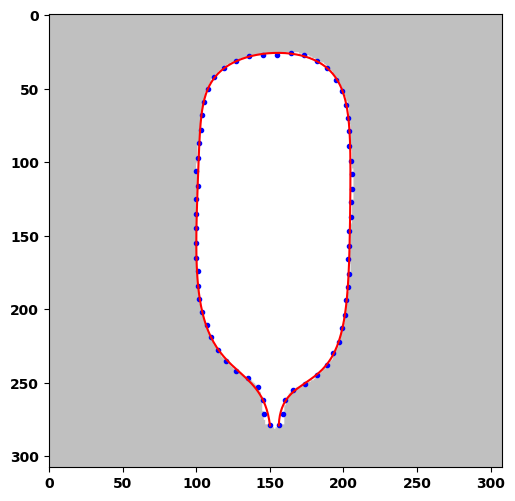

In [32]:
testOF(imgn=5,N=10,mode=0,err_th=0.5)

^^^^^^^.^^^^.^.
CP 5.0, steps:14, etime: 6.85938 err: 3.5340520569
^^^^.^^.^^.^^.^.........................^^^^^^^^^^^^^^^^^^^^^^^^^....................
............^^^^^^^^^^^^.^^^.^....................................^^^^^^^^^^^^^.^^.^...........
CP 2.0, steps:194, etime: 39.28125 err: 1.9980757171
.....
..............................^^^^^^^^^^^^^^^.^...^.................................................
.^^^^^^^^^^^^^^^^^^...........................................................^^^^^^^^^^^^^^^^.^.^.^
...^..........................................^^^^^^^^^^^^^^^^^^^^^.......^.........................
.................^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^^^.^^^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
.^^^^.^.^.^.^^^.^^^^^^^^.^.^.^.^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^..^.^^.^.^.^^^^.^.^.^^^
^.^.^.^.^..^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.9957592178508918, array([0, 1], dtype=int64))

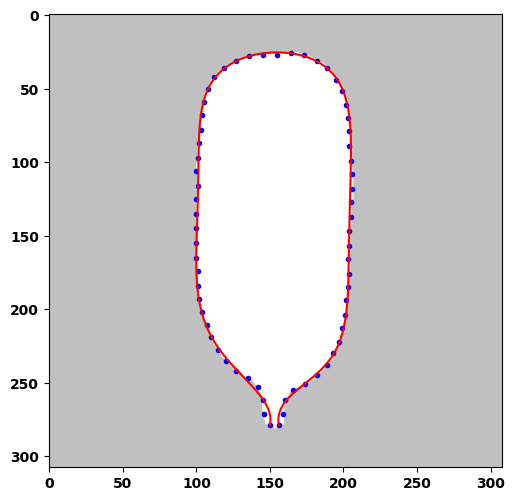

In [31]:
testOF(imgn=5,N=9,mode=0,err_th=1)

^^^^^.^.^.^^^^.^.^^^^.^^.^...........^^^^^^.^^.^^..^^.^^..^..................^^^^^.^^^.^^...........
............^^^^^^^^^^^^.^...........^^^^^...............^^^^^^^^^^.^^^^^.^.^.......................
^^^^^^^^^^^^^^^^^^^...^..............................^^^^^^^^^^^^^^^^^^^^^^^^..^^.^.................
............^^^^^^^^^^^^^^..................^^^^^^^^^^.^.......^^^^^^^^^^^^^^.^^^^..................
............^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................^^^^^^^^^^^^.^.^^^^^^^^^^^^....
^^............................^^^^^^^^^^^^^....^^^^^^^^^^^.^^^...............^^^^^^^^^^^^^^.........
.....................^^^^^^^^^^^^^^^^^^^............................^^^^^^^^^^^^^...................
......^^^^^^^^^^^^^^^^.^............................................................................
...........^^^^^^^^^^^^.^^.^^.^^.^^.^^.^^.^..^..^..^.....^..^^.^^.^^.
CP 5.0, steps:868, etime: 138.70312 err: 4.9937530837
^^.^^.^^.^^.^^.^..^..^..^...^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(4.8734235327228514,
 array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64))

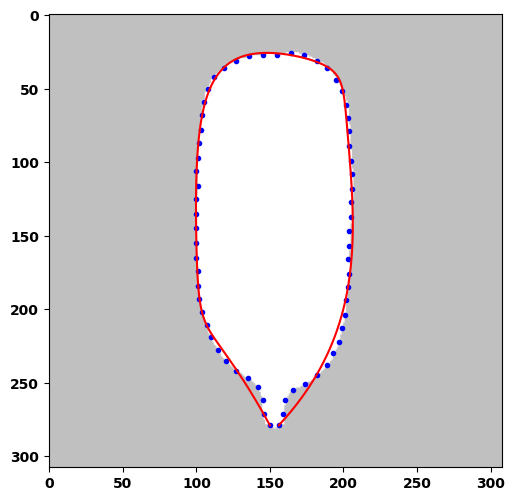

In [30]:
testOF(imgn=5,N=8,mode=0,err_th=1)

^^^^^^^^^^^^^.^.^.
CP 5.0, steps:17, etime: 9.53125 err: 4.5435643051
^..^.^...............................................................^^^^^..^^^^.^
^^...^^^...^....^....^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..
.......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 2.0, steps:395, etime: 107.35938 err: 1.9366345086
....
..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^.......^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.........^^^^...............^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^............
CP 1.0, steps:572, etime: 153.81250 err: 0.9983760091
..^^..................^^^^^
^^^^^^^^^^^^^^^^^...........^.^^^^^^^^^^^^^^^.^.^.^..^^^^^^^^^^^^^^^^^^^^^^..
CP 0.65, steps:676, etime: 180.78125 err: 0.6429531236
.......................
..........^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......E



(0.49712800549062075, array([], dtype=int64))

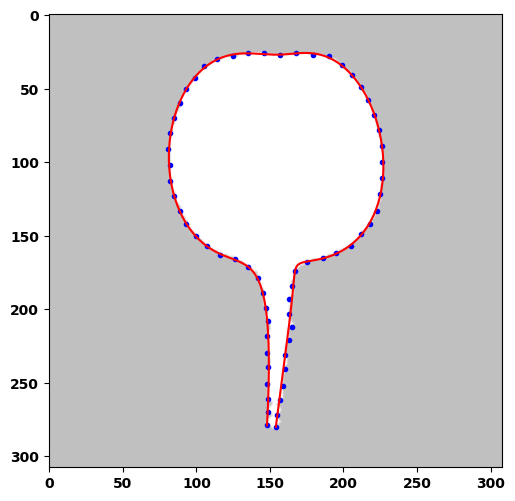

In [29]:
testOF(imgn=4,N=12,mode=0,err_th=0.5)

ABOVE

^^^^^^^^^^^^^.^.^.
CP 5.0, steps:17, etime: 9.26562 err: 4.5435643051
^..^.^...............................................................^^^^^..^^^^.^
^^...^^^...^....^....^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..
.......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 2.0, steps:395, etime: 107.09375 err: 1.9366345086
....
..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^.......^^^^^^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.........^^^^...............^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^............E



(0.9983760090744074, array([], dtype=int64))

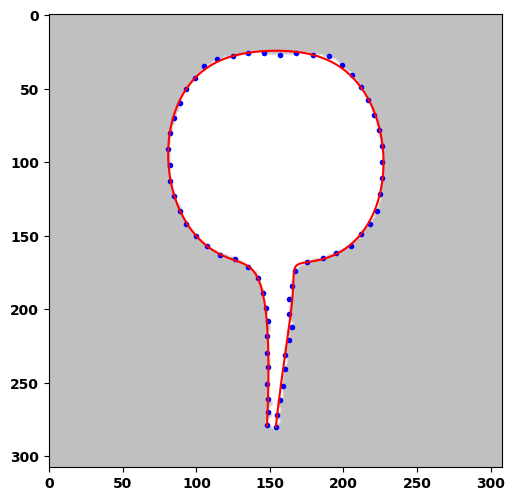

In [28]:
testOF(imgn=4,N=12,mode=0,err_th=1)

^^^^^^^^^.^.^^.^.^..^................................
CP 5.0, steps:52, etime: 15.17188 err: 4.9777140652
...............................................
.....................^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^^^^^^^^^^^^^......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.....................................................C



(2.0572477674800376, array([52], dtype=int64))

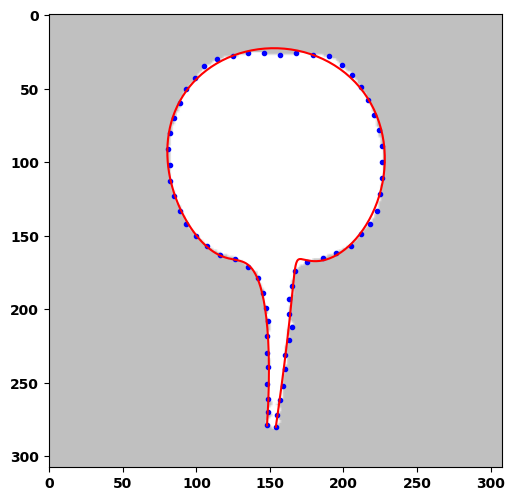

In [27]:
testOF(imgn=4,N=10,mode=0,err_th=0.65)

^^^^^^^^.^....^..........................
CP 5.0, steps:40, etime: 13.51562 err: 4.9850102513
..........................................^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........
..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(2.0578811704777245,
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53], dtype=int64))

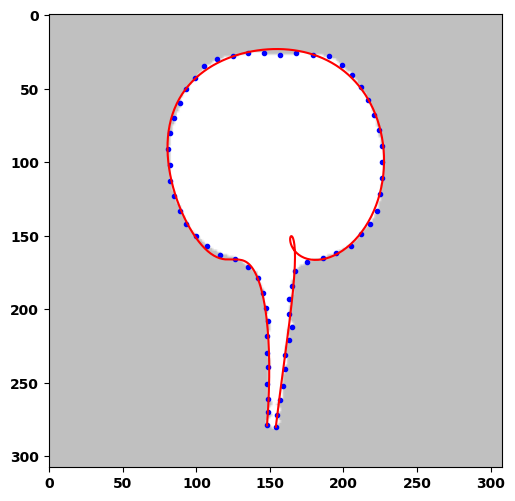

In [25]:
testOF(imgn=4,N=11,mode=0,err_th=1)

^^^^^.^.^^^^^^.^.^..
CP 5.0, steps:19, etime: 8.35938 err: 4.2559491509
^..^............................................................................
..................^^^^^^^^^.^^..^^............................................^^^^^^^^.
CP 2.0, steps:186, etime: 42.57812 err: 1.9954706407
^^.^^.^......
.....................................^^^^^^^^^^^^.^^^..^.^........................................^^
^^^.^^^^.^^^^.^.^................................................^^^^^^^^^^^^^^^.^.^^.^.^^.^^^^.^^.^
^^^.^^.^^.^..^.^^.^^.^^.^..^..^..^^^^^^^^^^^^^^^^^^..^.^.^............................^^^^^^^^^^^^^^
^................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........^...^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
^^^^.^^.
CP 1.0, steps:807, etime: 170.14062 err: 0.9814168736
^^.^^.^^.^^.^^.^^^.^..^

(0.4993464247474607, array([], dtype=int64))

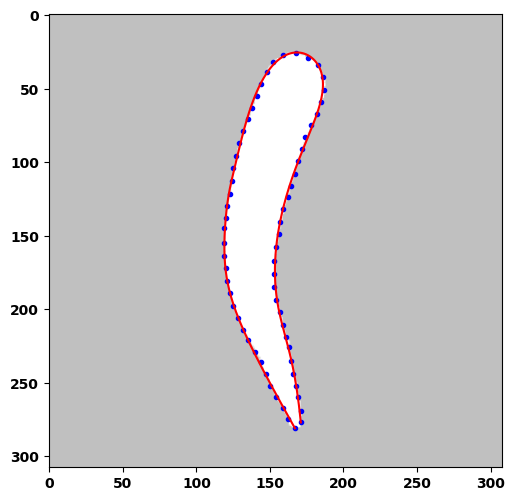

In [24]:
testOF(imgn=2,N=10,mode=0,err_th=0.5)

^^^.^.^.^.^.^..^.^..^..^....................^^.^^^.^^^..^............
CP 5.0, steps:68, etime: 11.29688 err: 4.9908951497
...........^^^^^^^^..^.........
......................^^^^^^.^^^^.^.^....................................^^^^^^^^^^..^..............
................................................^^^^^^^^^^.^^.^.^...................................
...................^^^^^^^^^^^.^.^.^.^.^................................................^^^^^^^^^.^.
^^^.^..^.^..^.^....^....^....^....^..^.^..^................^^^^^^^^.^^^^^^..........................
......................^^^^^...
CP 2.0, steps:529, etime: 72.10938 err: 1.9819318601
.^......^^^^^^^^^^^^^.^.^.^.^.........................................
................................^^^^^^^^^^^^^^^.^.^.^.^.............................................
............................^^^^^^^^^^^^^^^^^^^.^.^.................................................
...................
CP 1.0, steps:818, etime: 109.82812 err: 0.9989368598
..^^^^^^^^^

(0.485434040981066, array([], dtype=int64))

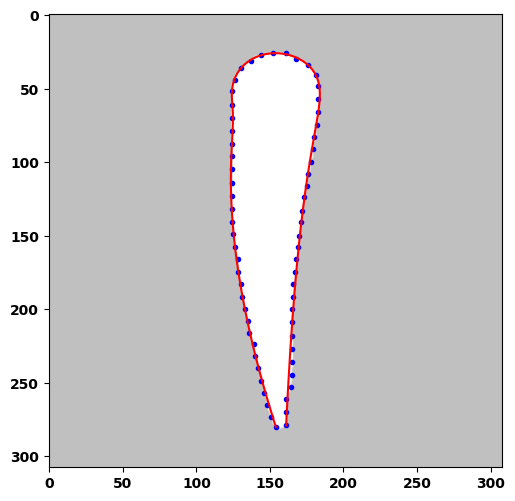

In [23]:
testOF(imgn=3,N=7,mode=0,err_th=0.5)

^^^.^.^.^.^.^..^.^..^..^....................^^.^^^.^^^..^............
CP 5.0, steps:68, etime: 11.71875 err: 4.9908951497
...........^^^^^^^^..^.........
......................^^^^^^.^^^^.^.^....................................^^^^^^^^^^..^..............
................................................^^^^^^^^^^.^^.^.^...................................
...................^^^^^^^^^^^.^.^.^.^.^................................................^^^^^^^^^.^.
^^^.^..^.^..^.^....^....^....^....^..^.^..^................^^^^^^^^.^^^^^^..........................
......................^^^^^...
CP 2.0, steps:529, etime: 72.26562 err: 1.9819318601
.^......^^^^^^^^^^^^^.^.^.^.^.........................................
................................^^^^^^^^^^^^^^^.^.^.^.^.............................................
............................^^^^^^^^^^^^^^^^^^^.^.^.................................................
...................E



(0.9989368598206712, array([], dtype=int64))

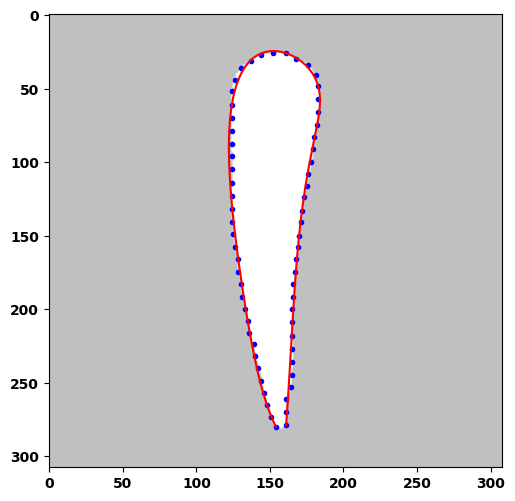

In [22]:
testOF(imgn=3,N=7,mode=0,err_th=1)

^^^^^^^^^.^......^..^........^......................................................................
...................................................................................^^^^^^^.^.^....
CP 5.0, steps:197, etime: 33.51562 err: 4.9898289664
..
..............................................^^^^^^.^.^.^..........................................
........^^^^^.^.^.^.................................................^^^^^^^^^.^.^.^.^.^.^^^..
CP 2.0, steps:392, etime: 63.28125 err: 1.9538100678
.^^^...
.......................................................^^^^^^^^^^^^^^^.^^.^.........................
.......E



(0.9975040186477279, array([], dtype=int64))

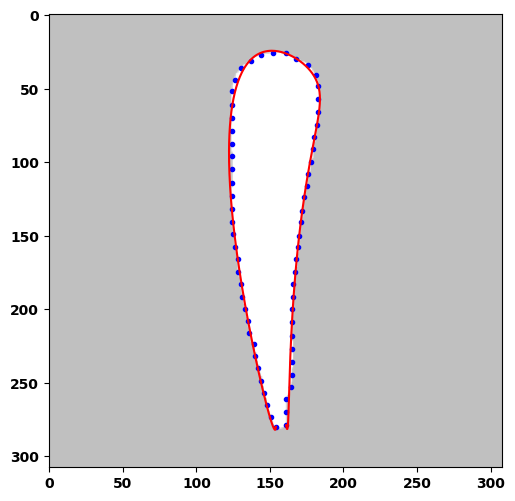

In [21]:
testOF(imgn=3,N=8,mode=0,err_th=1)

..................
CP 5.0, steps:17, etime: 14.78125 err: 4.8426560887
....................
CP 2.0, steps:37, etime: 27.73438 err: 1.9741953111
............................
CP 1.0, steps:65, etime: 45.89062 err: 0.9896702547
..................................
....................................^^..............................^^^.^.^.^.^.....................
..^^^^.^^^..................^^^^^^^.^.^^^^^^..^^^......^^^^^^^^^.^^..^.........^^^^^^^^^^^^^..^.^.^^
^....^.........^^^^^^^^^^^^^^^.^^^^.^^.....^^..^.^^^^^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^.^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^.^^^^^^^^^^^^^^.^^^^^^^^^^^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.757507535284728, array([57], dtype=int64))

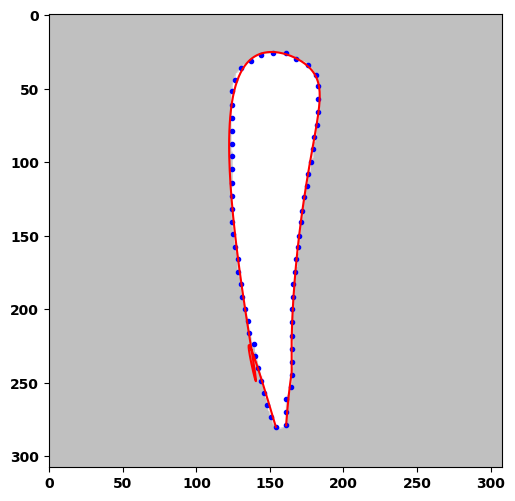

In [18]:
testOF(imgn=3,N=8,mode=1,err_th=0.65)

............................
CP 5.0, steps:27, etime: 16.28125 err: 4.9745638277
........................................................................
.........................................
CP 2.0, steps:140, etime: 72.39062 err: 1.9861723310
...........................................................
....................................................................................................
......................................
CP 1.0, steps:337, etime: 170.76562 err: 0.9990835237
..............................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................^.........................
....................^..^......

(0.8390922362350557, array([], dtype=int64))

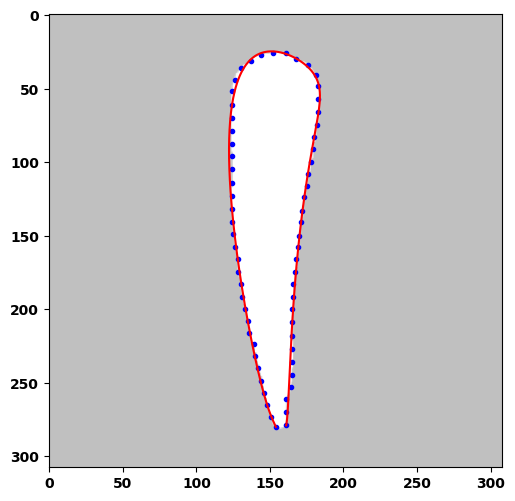

In [17]:
testOF(imgn=3,N=7,mode=1,err_th=0.65)

...................................................................
CP 5.0, steps:66, etime: 26.54688 err: 4.9813033700
.................................
...................................
CP 2.0, steps:134, etime: 51.68750 err: 1.9955004629
.................................................................
...........................................................
CP 1.0, steps:258, etime: 97.93750 err: 0.9992494671
.........................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................C



(0.8467174101255627, array([], dtype=int64))

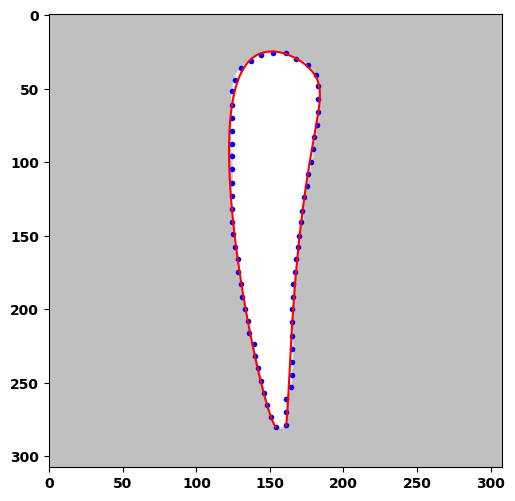

In [16]:
testOF(imgn=3,N=6,mode=1,err_th=0.65)

^^^.^.^.^.^..^.^....................................................................................
........^^^^.^^.^^............................................................^^^^.^....^...........
.......................................................^^^^^^^.^.^...............................
CP 5.0, steps:296, etime: 34.65625 err: 4.9782113381
...
.......................^^^^^^^^^.^.^.........................................................^^^^^^^
^^^^^^^.^^.^.^.^.^^^^^^.^.^^^^^^.^.^.^^^^.^.^.^^.^.^.^^.^.^.^..^.^.^..^.^^^^^^^^^^.^.^..^.^.........
................................^^^^^^^^^^^^^^.^............
CP 2.0, steps:559, etime: 63.70312 err: 1.9942787934
........................................
.......................^^^^^^^^^^^^^^^^...^.........................................................
.....................^^^^^^^^^^^^^^^.^.^.^..^.......................................................
..........^^^^^^^^^^^^^^^^^^^^^.
CP 1.0, steps:831, etime: 93.70312 err: 0.997855734

(0.6499487792290577, array([], dtype=int64))

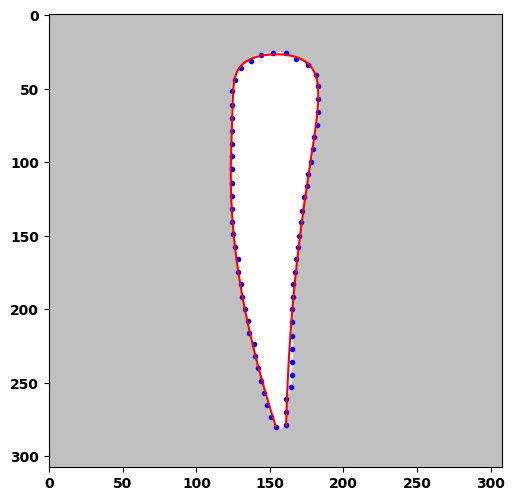

In [15]:
testOF(imgn=3,N=6,mode=0,err_th=0.65)

^^^.^.^.^.^..^.^....................................................................................
....................................................................................................
......................................................
CP 5.0, steps:253, etime: 24.28125 err: 4.9700105146
..............................................
.......................................................................................
CP 2.0, steps:386, etime: 36.53125 err: 1.9900520603
.............
....................................................................................................
.....................................................E



(0.9996392121361694, array([], dtype=int64))

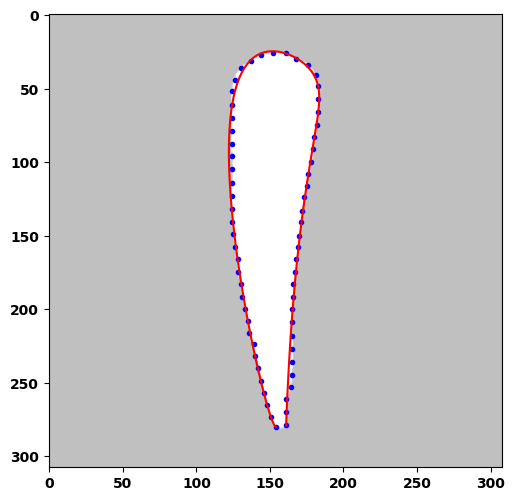

In [14]:
testOF(imgn=3,N=5,mode=0,err_th=1)

^^^^^^^^^^^^^^^
CP 5.0, steps:14, etime: 9.70312 err: 3.2252752234
^.
CP 2.0, steps:16, etime: 10.32812 err: 1.5550908237
^^^^.^..^..^^.^^...................................................................
........^^^^^^^^^^^^^.............................................^^^^^^^^^^..^....^....^^..........
..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
CP 1.0, steps:246, etime: 82.43750 err: 0.9612397899
..^^^^^^^^^^^^^^^^....^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7978410440043054,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 27,
        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 48, 49, 50, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64))

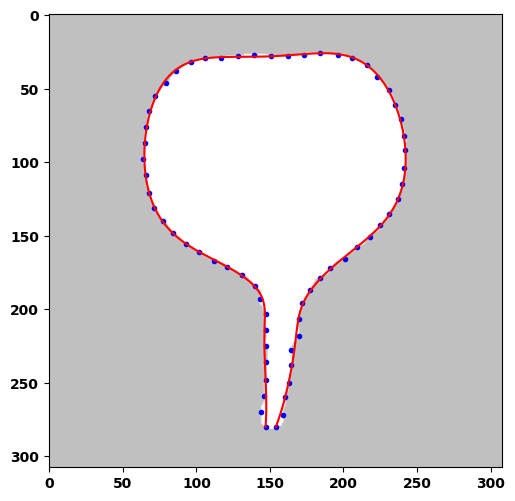

In [12]:
testOF(imgn=1,N=14,mode=0,err_th=0.5)

^^^^^^^^^^^^
CP 5.0, steps:11, etime: 9.35938 err: 3.3622083688
^^^^^^.
CP 2.0, steps:18, etime: 11.67188 err: 1.5746446746
.^.
CP 1.0, steps:21, etime: 12.67188 err: 0.9766661563
^^.^..^..^....................................................................
............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^..^^^.................
....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^....
CP 0.65, steps:415, etime: 147.18750 err: 0.6484297020
..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^...................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........E



(0.49971564965267323, array([], dtype=int64))

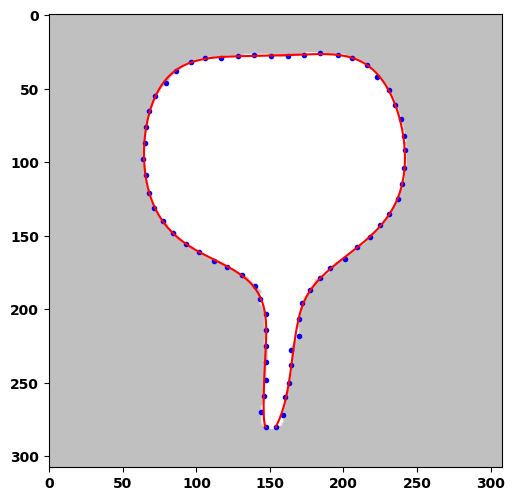

In [11]:
testOF(imgn=1,N=15,mode=0,err_th=0.5)

^^^^^^^^.^..^.^.^....^..^........................^^^^^^^^^^^^^^^.^^^..............^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^..
CP 5.0, steps:180, etime: 45.56250 err: 4.9720826635
...................
...............^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^..^^^..^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^..^.^^^^^^^^^^.^....^^^^^........^..............
......^.^^^^^^^^^^^^.^^..^^^...................................^^^^^^^^^^^^^^^.^.^......^.^.........
..............^.^.^^^^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..
CP 2.0, steps:689, etime: 161.17188 err: 1.9950800574
...^^^^^^^
................................^^^^^^^^^^^^^^^^^^^^^^^^.^^^^................^.^^^^^^^^^^^^^^^.^..^.
....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7699636611107719,
 array([11, 12, 14, 20, 21, 22, 24, 25, 26, 28, 30, 39, 40, 41, 42, 47, 49,
        50, 51, 52, 53, 55, 58], dtype=int64))

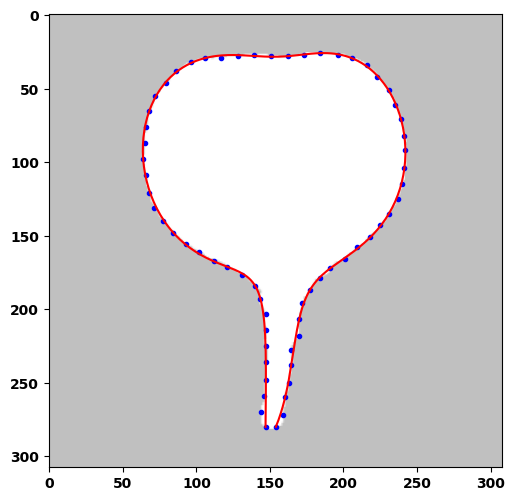

In [10]:
testOF(imgn=1,N=11,mode=0,err_th=0.65)

^^^^^^^^^^^^^^.
CP 5.0, steps:14, etime: 8.42188 err: 4.1676197870
^.^^.^..^..^..^......................................................................
....................................................................................................
...............................................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^.
CP 2.0, steps:319, etime: 85.64062 err: 1.9966429889
............^^..............................................^^^^^^^^^^^^^^^^^^^^
.^^^^.^^^^^........^^....................^.^^^^^^^^^^^^^^^^.^.^.^.^.^.^^^...........................
.......^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............................^^^^^^^^^^^^
^^^^^....^........^^^^^^^^^^^.
CP 1.0, steps:629, etime: 164.39062 err: 0.9390680465
^^....^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6481400868990989, array([], dtype=int64))

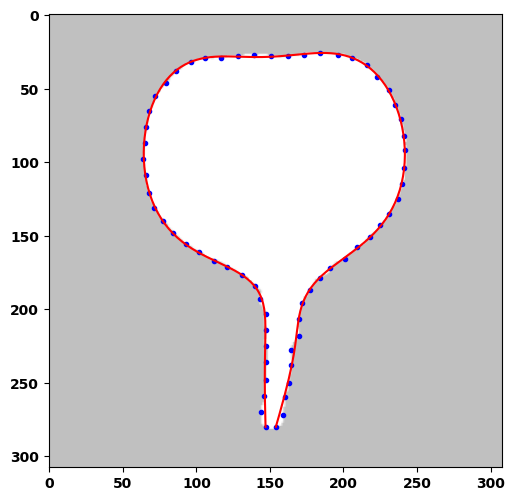

In [9]:
testOF(imgn=1,N=12,mode=0,err_th=0.65)

^^^^^^^.
CP 5.0, steps:7, etime: 7.04688 err: 4.3475397404
^^^^^^.^.^^.^^.^..^..^........................^^^^^^^^^^^^...................^^^^^^^^^^^^^^^
^......................^^^^^^^^^^^.^^...
CP 2.0, steps:139, etime: 44.12500 err: 1.9975316584
.^.........................^^^^^^^^^^^^^^^^^........^^^.....
....................^^^^^^^^^^^^^^^^.^.........^............................^^^^^^^^^^^^^^^^^......^
..^...............................^^^^^^^^^^^^^^^^.^.^..^..^...............................^^^^^^^^^
^^^^^^.^.^.^.^.^^..^.............................^^^^^^^^^^^^^^^^^.^.^.^^^^.^.^.^^.^.^.^..^.^.......
.......^^^^^^^^^^^^^^^^^^^^^^............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....
CP 1.0, steps:759, etime: 219.21875 err: 0.9967783522
..................^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.648495146434196, array([], dtype=int64))

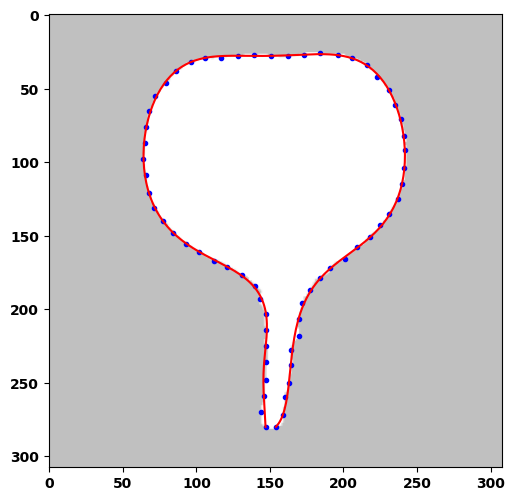

In [8]:
testOF(imgn=1,N=13,mode=0,err_th=0.65)

^^^^^^^^^^^^^^^
CP 5.0, steps:14, etime: 9.60938 err: 3.2252752234
^.
CP 2.0, steps:16, etime: 10.21875 err: 1.5550908237
^^^^.^..^..^^.^^...................................................................
........^^^^^^^^^^^^^.............................................^^^^^^^^^^..^....^....^^..........
..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
CP 1.0, steps:246, etime: 81.56250 err: 0.9612397899
..^^^^^^^^^^^^^^^^....^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7978410440043054,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 27,
        28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 48, 49, 50, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64),
 Matrix([
 [     154.0*t**14 + 191.178*t**13*(14 - 14*t) + 16109.7*t**12*(1 - t)**2 - 20068.9*t**11*(1 - t)**3 + 882662.0*t**10*(1 - t)**4 + 363249.0*t**9*(1 - t)**5 - 3.20612e+6*t**8*(1 - t)**6 + 1.01015e+7*t**7*(1 - t)**7 - 1.04045e+7*t**6*(1 - t)**8 + 6.43979e+6*t**5*(1 - t)**9 - 2.05179e+6*t**4*(1 - t)**10 + 321146.0*t**3*(1 - t)**11 + 1129.91*t**2*(1 - t)**12 + 2212.06*t*(1 - t)**13 + 147.0*(1 - t)**14],
 [280.0*t**14 + 185.412*t**13*(14 - 14*t) - 7629.33*t**12*(1 - t)**2 + 595035.0*t**11*(1 - t)**3 - 4.98025e+6*t**10*(1 - t)**4 + 2.45546e+7*t**9*(1 - t)**5 - 6.21056e+7*t**8*(1 - t)**6 + 8.30048e+7*t**7*(1 - t)**7 - 5.87579e+7*t**6*(1 - t)**8 + 2.16245e+7*t**5*(1 - t)**9 - 3.90903e+6*t**4*(1 - t)**10 + 433020.0*t**3*(1 - t)**11 + 4053.12*t**2*(1 - t)**1

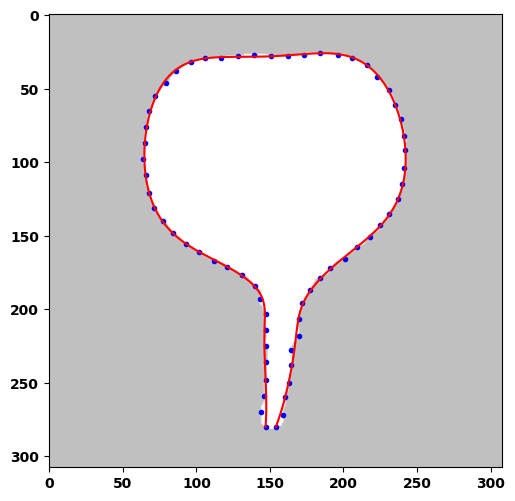

In [65]:
testOF(imgn=1,N=14,mode=0,err_th=0.65)

^^^^^^^^^^^^
CP 5.0, steps:11, etime: 9.59375 err: 3.3622083688
^^^^^^.
CP 2.0, steps:18, etime: 11.87500 err: 1.5746446746
.^.
CP 1.0, steps:21, etime: 12.85938 err: 0.9766661563
^^.^..^..^....................................................................
............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.....^^^^^^^^^^^^^^^^^^^^^..^^^.................
....^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^....E



(0.6484297019985873, array([], dtype=int64))

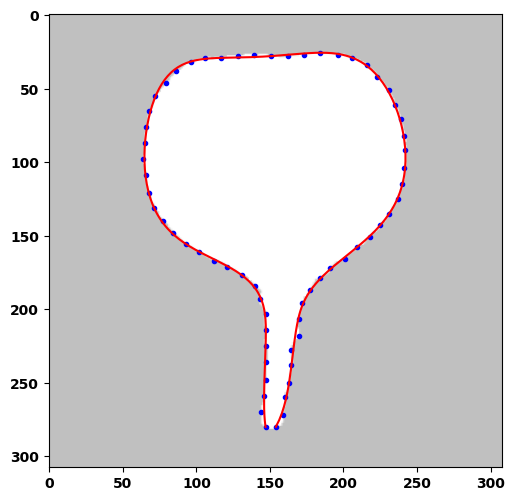

In [6]:
testOF(imgn=1,N=15,mode=0,err_th=0.65)

^^^^^.^.^^^^^^.^.^..
CP 5.0, steps:19, etime: 8.32812 err: 4.2559491509
^..^............................................................................
..................^^^^^^^^^.^^..^^............................................^^^^^^^^.
CP 2.0, steps:186, etime: 41.18750 err: 1.9954706407
^^.^^.^......
.....................................^^^^^^^^^^^^.^^^..^.^........................................^^
^^^.^^^^.^^^^.^.^................................................^^^^^^^^^^^^^^^.^.^^.^.^^.^^^^.^^.^
^^^.^^.^^.^..^.^^.^^.^^.^..^..^..^^^^^^^^^^^^^^^^^^..^.^.^............................^^^^^^^^^^^^^^
^................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.........^...^...^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^.................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
^^^^.^^.
CP 1.0, steps:807, etime: 163.82812 err: 0.9814168736
^^.^^.^^.^^.^^.^^^.^..^

(0.643630157100576, array([], dtype=int64))

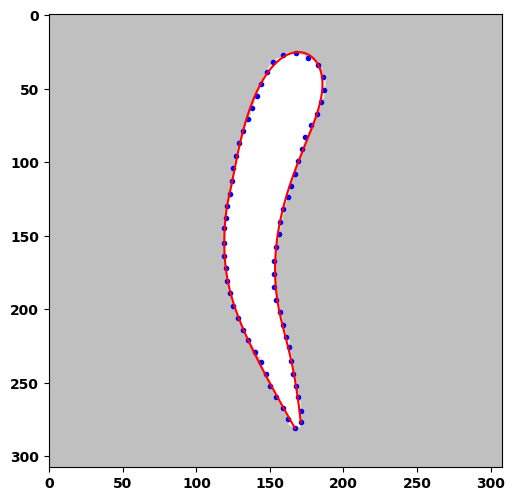

In [7]:
testOF(imgn=2,N=10,mode=0,err_th=0.65)

^^^^^^^^.^^..^....
CP 5.0, steps:17, etime: 7.46875 err: 3.3974458507
^.^..^.....^......................................................................
....................................................................................................
.........................................................
CP 2.0, steps:256, etime: 51.85938 err: 1.9981058692
..................^^^^^^^^^^^^^^^^^^^^^^^..
................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................^^^^^^^^^^^^^^^^^^^^^^.....................
........^^^^^^^^^^^^^^^^^^^^^^^^^^^^..................^^^^^^^^^^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^.^^^.^^.^^..^..^......^^^^^^^^^^^^^^^^^^^^^..^.^...........^^^^^^
^^^^^^^^^^...^..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.9998681896851572, array([], dtype=int64))

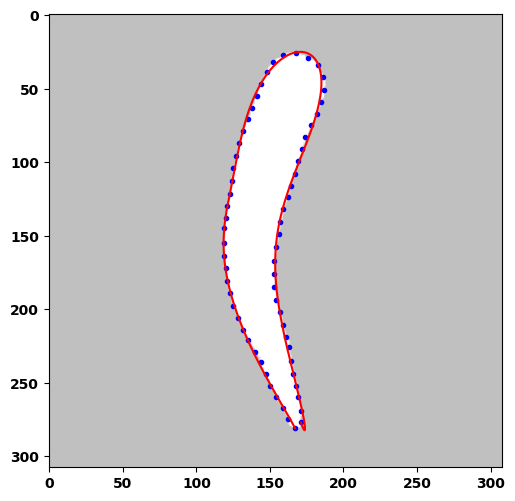

In [56]:
testOF(imgn=2,N=9,mode=0,err_th=1.0)

^^^^^^^^
CP 5.0, steps:7, etime: 16.03125 err: 3.3208907416
^.^^^^^^.
CP 2.0, steps:16, etime: 19.31250 err: 1.1562886628
^^^^.^^.
CP 1.0, steps:24, etime: 22.25000 err: 0.9893758964
^^.^^..^..^................................................................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^..
...........
CP 0.65, steps:210, etime: 92.01562 err: 0.6490709106
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
...............^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^.^^^.E

[] [array([1.81612488, 1.78639425, 2.27695954, 2.47626088, 1.76581021,
       3.79200591])]


(0.4941774550998047, array([], dtype=int64))

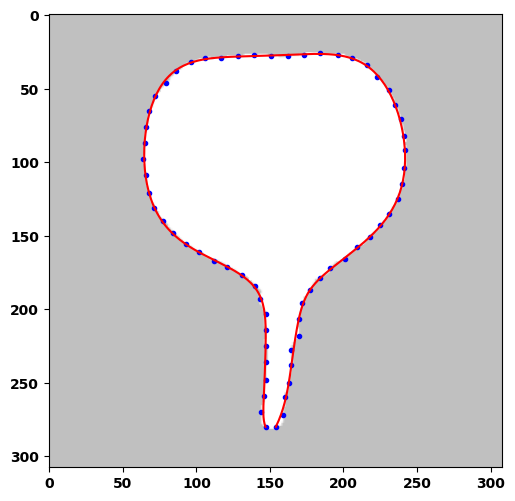

In [54]:
testOF(imgn=1,N=16,mode=0,err_th=0.5)

^^^^^^^^^^^^
CP 5.0, steps:11, etime: 21.56250 err: 3.3915513187
^^^.
CP 2.0, steps:15, etime: 23.15625 err: 1.7689234024
........
CP 1.0, steps:23, etime: 26.34375 err: 0.9662280653
.............................^......................^...^^^^^^^^^^^^^^^^^^^^
^^^^^.^^^.
CP 0.65, steps:109, etime: 60.73438 err: 0.6372752135
^^^^^^^^.......................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^.E

[] [array([1.50493291, 3.19892416, 1.72502114, 1.77297236, 1.93535787,
       2.25660125, 1.89169447, 2.74433683])]


(0.46387761430387464, array([], dtype=int64))

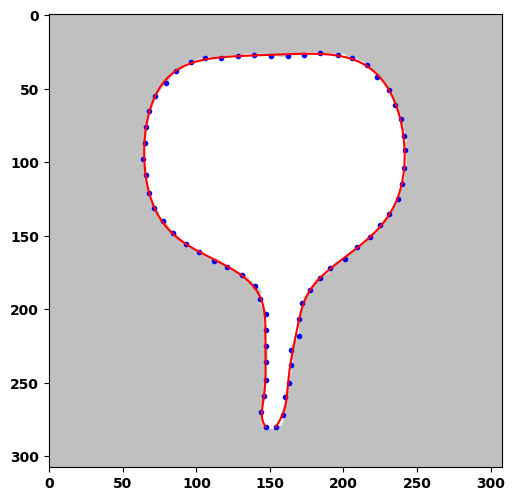

In [55]:
testOF(imgn=1,N=17,mode=0,err_th=0.5)

^^^^^^^^^^^^^^
CP 5.0, steps:13, etime: 15.87500 err: 2.8294721695
^^.^.
CP 2.0, steps:18, etime: 17.51562 err: 1.9124202487
.^.^^^^.....^....................................................................
....
CP 1.0, steps:103, etime: 47.26562 err: 0.9995295617
................................................................................................
......................................................................^^^^^^^^^^^^^^^^^^^^^^^^^.....
.................E

[] [array([2.60923245, 2.76269864, 2.36591312, 2.75005786, 2.08910987,
       2.54690121])]


(0.649647187855513, array([], dtype=int64))

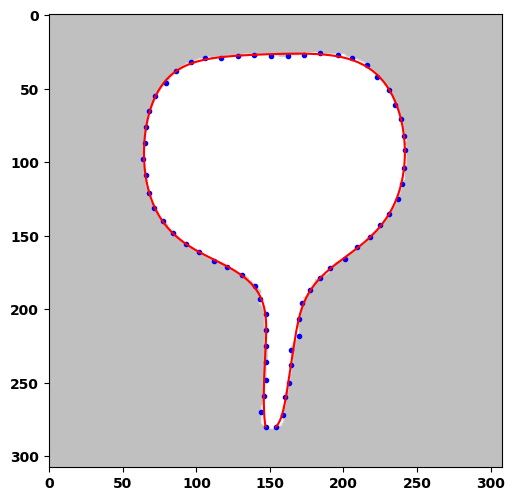

In [52]:
testOF(imgn=1,N=15,mode=0,err_th=0.65)

^^^^^^^^
CP 5.0, steps:7, etime: 16.14062 err: 3.3208907416
^.^^^^^^.
CP 2.0, steps:16, etime: 19.39062 err: 1.1562886628
^^^^.^^.
CP 1.0, steps:24, etime: 22.31250 err: 0.9893758964
^^.^^..^..^................................................................
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^..
...........
CP 0.65, steps:210, etime: 92.81250 err: 0.6490709106
......^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
...............^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^.^^^.E

[] [array([1.81612488, 1.78639425, 2.27695954, 2.47626088, 1.76581021,
       3.79200591])]


(0.4941774550998047, array([], dtype=int64))

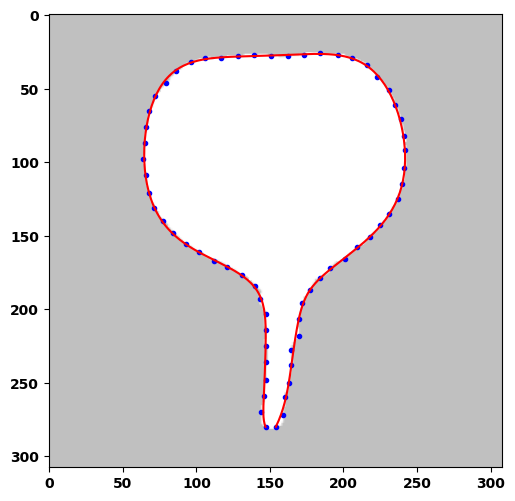

In [53]:
testOF(imgn=1,N=16,mode=0,err_th=0.5)

^^^^^^^^^^^^^
CP 5.0, steps:12, etime: 13.81250 err: 4.9545001265
^^^...
CP 2.0, steps:18, etime: 15.65625 err: 1.9623542923
^.^^.^^..^^.........................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^.^^^^^^^^^^^^^^^^^^^......................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^........
CP 1.0, steps:208, etime: 75.59375 err: 0.9940987723
............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...........................^.^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^..^^...........^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^..^^^^..
CP 0.65, steps:554, etime: 185.40625 err: 0.6474662258
..^^^^^^^^^......^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5959720790365336, array([55], dtype=int64))

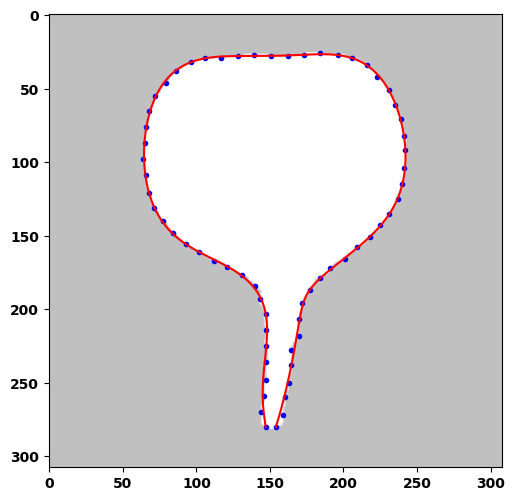

In [50]:
testOF(imgn=1,N=14,mode=0,err_th=0.5)

^^^^^^^^^^^^^^^
CP 5.0, steps:14, etime: 12.89062 err: 4.4669081932
^.^..^..^..^..^^.....................................................................
....................................................................................................
.................................................
CP 2.0, steps:248, etime: 80.79688 err: 1.9978494621
..........................^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...............................................^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^...
CP 1.0, steps:655, etime: 200.51562 err: 0.9811797672
......^^^^^^^^^^^^^^^^^^^...................
.........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7097518002604921, array([58, 59, 60, 62, 63], dtype=int64))

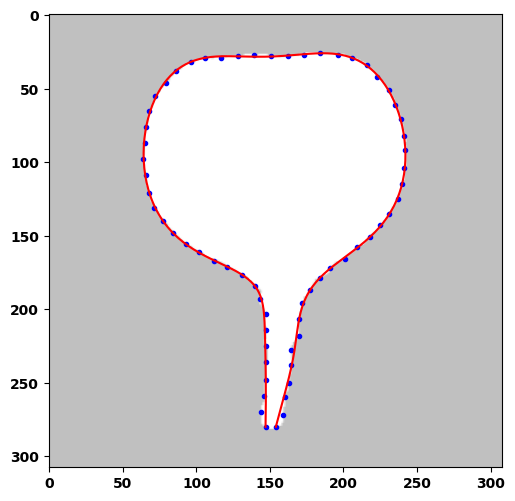

In [49]:
testOF(imgn=1,N=13,mode=0,err_th=0.5)

^^^^^^^^^^^^^^.
CP 5.0, steps:14, etime: 11.04688 err: 4.3159482775
^.^^.^^.^..^..^......................................................................
^^^^^^^^^.^^^..................................^^^^^^^^^^^^^^^^^^^^^^^^^^^^......^..................
.^^^^^^^^^^^^^^^^^^^^^^^^.^^^^....^^^...................^.^^^^^^^^^^^^^^^^....^...^^^...............
........^..^^^^^^^^^^^^^..^^..........^..............................^^^^^^^^^^^^^^^^^^........^^^..
....................................^^^^^^^^^^^^^^^^^^^...^.^.^^^....
CP 2.0, steps:468, etime: 128.29688 err: 1.9967557516
...............................
......^^^^^^^^^^^^^^^^^.^.^..^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..............................^^^^^
^^^....^^^^^^^^..........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
CP 1.0, steps:674, etime: 180.93750 err: 0.9587210613
.........................
...............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6612628448041215, array([], dtype=int64))

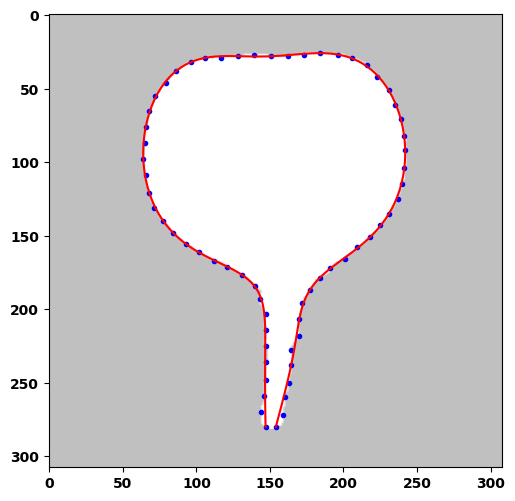

In [48]:
testOF(imgn=1,N=12,mode=0,err_th=0.5)

^^^^^^^^^.^^^.^.^.^.^...............................................................................
......................
CP 5.0, steps:121, etime: 30.79688 err: 4.9988407057
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..............................^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^..
...............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............................
...........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^.^^^^^^^^^^^^...
CP 2.0, steps:726, etime: 156.56250 err: 1.9875125334
............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................

(0.9910010065477725, array([], dtype=int64))

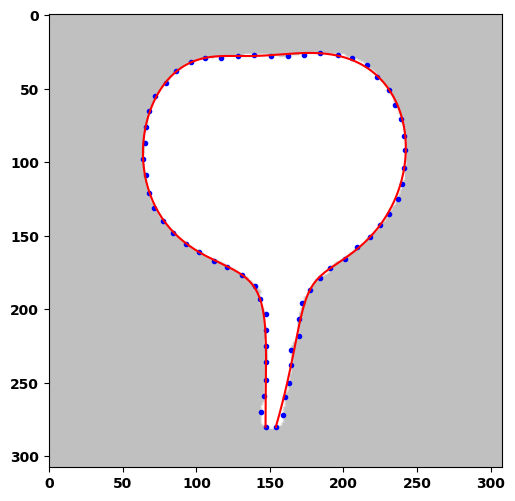

In [41]:
testOF(imgn=1,N=10,mode=0,err_th=1)

^^^^.^........^.....................................................................................
........................................................................................^^^^^.^^.^..
^..................................................
CP 5.0, steps:250, etime: 36.85938 err: 4.9913307508
.......................^^^^.^.^.^....^...........
......................
CP 2.0, steps:321, etime: 46.70312 err: 1.9831941224
........................^^^^^^^^^^^.^.^.^.....................................
.................^^^^^^^^^^^^^^^^^^.....E

[] [array([1.58528944, 2.15900398, 1.6548989 , 2.9735455 , 2.53832513])]


(0.9963500998298745, array([], dtype=int64))

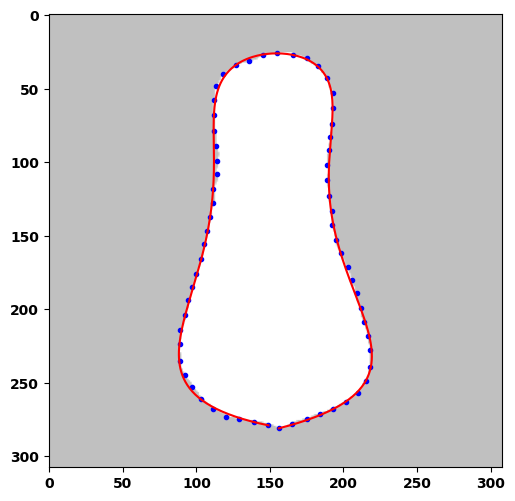

In [25]:
testOF(imgn=0,N=7,mode=0,err_th=1)

^^^.^.^.^.^..^.^....................................................................................
....................................................................................................
........................................
CP 5.0, steps:239, etime: 39.45312 err: 4.9542088165
............................................................
..........................
CP 2.0, steps:325, etime: 53.03125 err: 1.9852624075
..........................................................................
.................................................................^^^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^...
.^.^.^..................................^^^^^^^^^^^^^^^^^^^^^^^.....................................
.........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^...^..............
CP 1.0, steps:736, etime: 115.42188 err: 0.9997849069
^.^.^.^.^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^....^.^^^^

(0.49739660406823744, array([], dtype=int64))

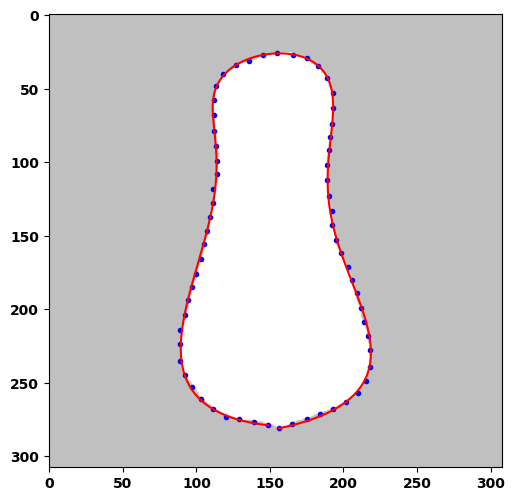

In [24]:
testOF(imgn=0,N=8,mode=0,err_th=0.5)

.....................................................................................
CP 5.0, steps:84, etime: 58.57812 err: 4.9085911684
...............
..........
CP 2.0, steps:109, etime: 74.89062 err: 1.9854089810
.....................
CP 1.0, steps:130, etime: 89.04688 err: 0.9817960167
..................
CP 0.65, steps:148, etime: 101.00000 err: 0.6443172570
.....................E

[] [array([1.83349963, 1.65517263])]


(0.4965834125046084, array([], dtype=int64))

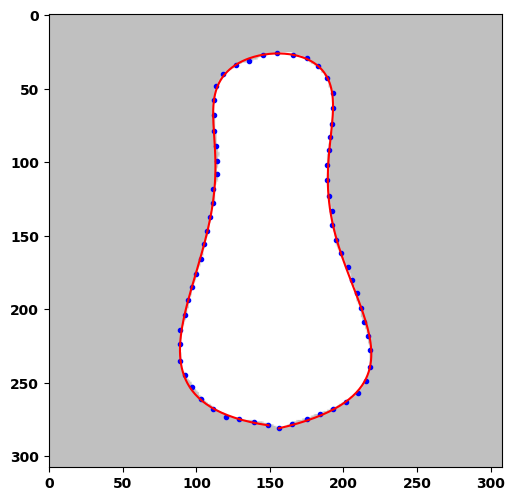

In [20]:
testOF(imgn=0,N=8,mode=1,err_th=0.5)

....
CP 5.0, steps:3, etime: 9.29688 err: 4.8226147760
........................................................................
CP 2.0, steps:75, etime: 81.89062 err: 1.9886757113
........................
.............................................................
CP 1.0, steps:160, etime: 167.78125 err: 0.9944535765
.......................................
.......................
CP 0.65, steps:222, etime: 230.81250 err: 0.6487741072
.............................................................................
.................................................E

[] [array([1.82871764, 2.02445713, 2.8651099 , 2.40172178, 1.99433878])]


(0.4999526885654096, array([], dtype=int64))

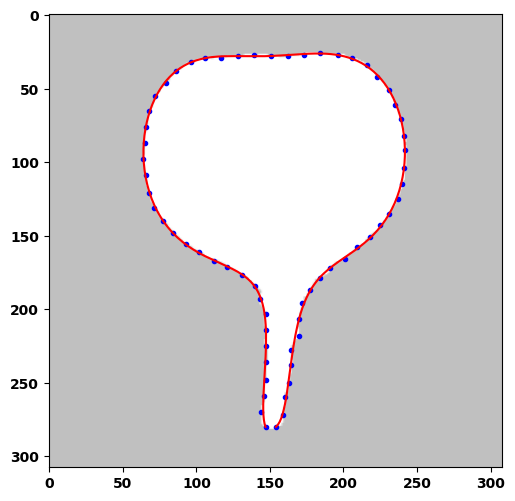

In [7]:
testOF(imgn=1,N=10,mode=1,err_th=0.5)

..............................................................................................
CP 5.0, steps:93, etime: 84.25000 err: 4.9965848423
......
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................
CP 2.0, steps:629, etime: 551.18750 err: 1.9918016908
......................................................................
..........................................................E

[] [array([4.03674788, 3.89402765, 2.31199772, 2.36127527, 2.326711  ,
       5.48981355])]


(0.9981112885317548, array([], dtype=int64))

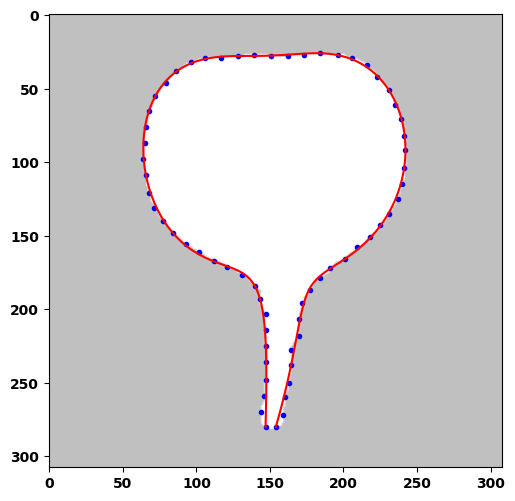

In [43]:
testOF(imgn=1,N=9,mode=1,err_th=1)

....
CP 5.0, steps:3, etime: 9.12500 err: 4.8226147760
........................................................................
CP 2.0, steps:75, etime: 82.75000 err: 1.9886757113
........................
.............................................................
CP 1.0, steps:160, etime: 170.71875 err: 0.9944535765
.......................................
.......................
CP 0.65, steps:222, etime: 234.32812 err: 0.6487741072
.............................................................................
.................................................E

[] [array([1.82871764, 2.02445713, 2.8651099 , 2.40172178, 1.99433878])]


(0.4999526885654096, array([], dtype=int64))

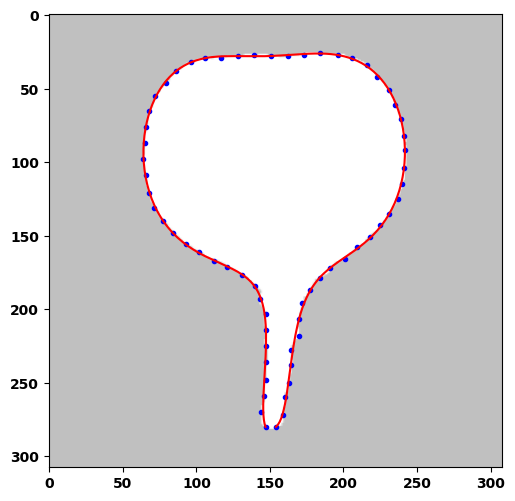

In [18]:
testOF(imgn=1,N=10,mode=1,err_th=0.5)

^^^^^^^^.^....^.^.^...........^^^^^^^^^^^^^^^^^............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^....
CP 5.0, steps:120, etime: 34.29688 err: 4.9399267692
...........^^^^^^.........^^^^^^^^^............................................
.........^^^^^^^^^^^^^^^^^^.^^^..^^..^^^....^^.^^^^^^^^.^^^^^^^^^^^.^^...............^.^^^^^^^^^^^^^
^...^^^...^..^^^^.....^^^^......^.^..^^^^^^^^^^^^^^^^^^....^^^^^^.^...^^^...^..^^^^.....^^^......^.^
^^^^^^^^^^^^^^^^^^^^^.^^^.^^^^..^^..^^^^..^...^^......^^^......^^......^^^^^^^^^^^^^^^^^.....^^^^^..
............^^^.....^.^.^^^^^^^^^^^^^^..^...........^^^^^^^^^^^^^^.^.^.^.^^^^^^^^^^^^^^.^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.
CP 2.0, steps:774, etime: 186.23438 err: 1.9785478445
.^^^...^^................
..............^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.7129086178028862, array([], dtype=int64))

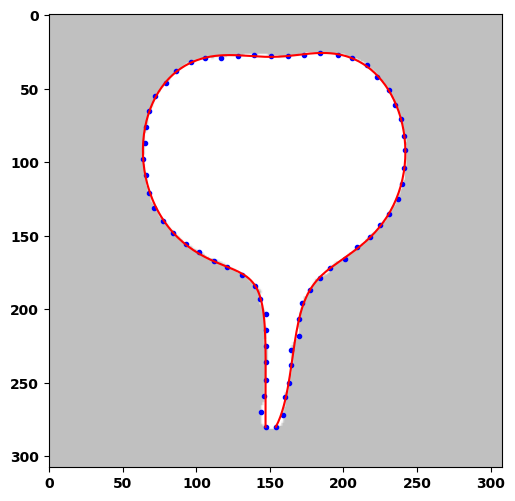

In [46]:
testOF(imgn=1,N=11,mode=0,err_th=0.5)

^^^^^^^^^.^^^.^.^.^.^...............................................................................
......................
CP 5.0, steps:121, etime: 31.40625 err: 4.9988407057
.....................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..........^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^..............................^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^....^..
...............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............................
...........^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^.^^^^^^^^^^^^...
CP 2.0, steps:726, etime: 162.29688 err: 1.9875125334
............................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.............................

(0.9910010065477725, array([], dtype=int64))

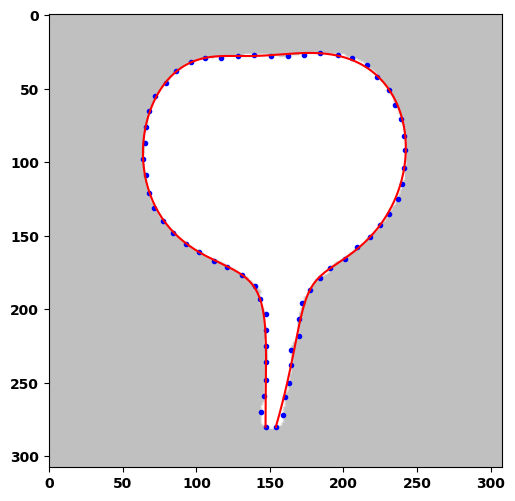

In [45]:
testOF(imgn=1,N=10,mode=0,err_th=1.0)

..............
CP 5.0, steps:13, etime: 12.93750 err: 4.9715770942
......................................................................................
....................
CP 2.0, steps:119, etime: 106.50000 err: 1.9992877280
................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................

(1.1089727123370137, array([], dtype=int64))

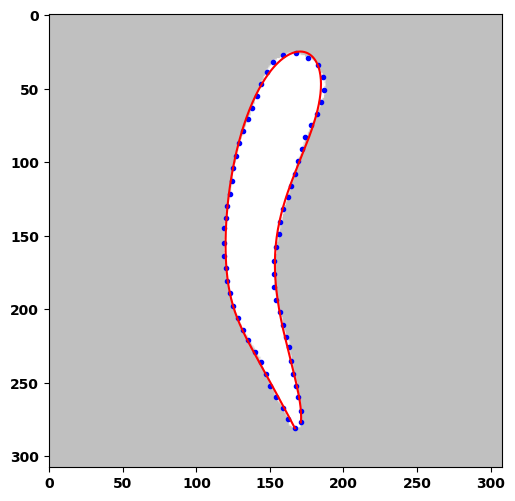

In [47]:
testOF1(imgn=2,N=7,err_th=1)

..............
CP 5.0, steps:13, etime: 12.71875 err: 4.9715770942
......................................................................................
....................
CP 2.0, steps:119, etime: 105.03125 err: 1.9992877280
................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................

(1.1102271933873824, array([], dtype=int64))

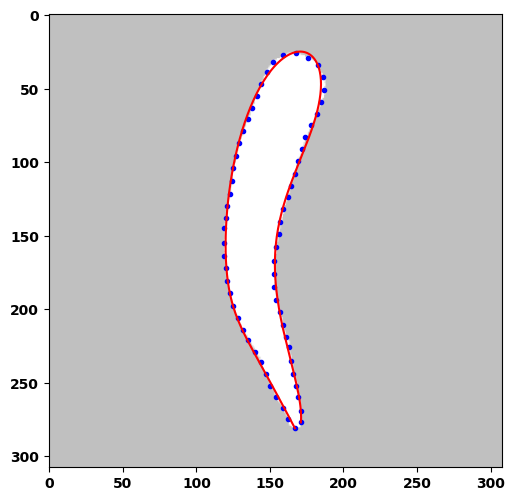

In [14]:
testOF1(imgn=2,N=7,err_th=0.5)

.......
CP 5.0, steps:6, etime: 8.23438 err: 4.6434441746
.........................
CP 2.0, steps:31, etime: 34.75000 err: 1.9916567540
..................................................^^^^^^^^^^...^....
.......^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^..........................
.................................................^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^^.^.^.^^.^.^..^.^.^..^.^.^..^...^^.^.^.^.^.^.^.^.^.^.^
.^.^..^....^....^....^.^^....^.^^....^.^^..^.^^..^.^^..^.....^^..^...^...^...^...^...^...^...^...^..
.^...^...^^^..^^...^^...^^....^^....^^......^^......^^......^^.......^^........^^.........^.........
.^......................................................................................

(0.9158429469224321, array([], dtype=int64))

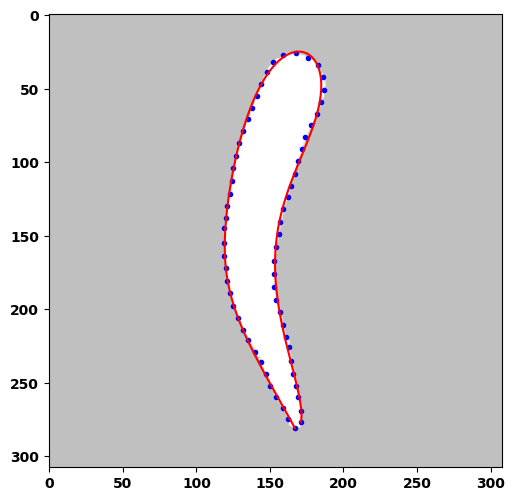

In [15]:
testOF1(imgn=2,N=11,err_th=0.5)